# Project 2 report, Group 57

*https://github.com/pp-22/pp-project-2-group-57*

William Jones, Niklas Weller, Whenzheng Zhang, Jiayi Li, Donghao Yao

# 1. Introduction:

Within this report we primarily focus on analysing yellow vs for-hire (FHVHV) taxi data in New York City, for a series of different metrics. We begin by cleaning the data given to us by the New York Commison [3], and then analyse taxi pick-ups and drop-offs by time of day and location; the journeys taxis take throughout New York City; the average tip taxi drivers receive over a week and by location, comparing this data to real income data; and finally take a look at the rush hour times of the day.

The NYC dataset is very large, and therefore to make sure we are working with reasonable data sizes, we will pick one month to focus on. We want this data to be representative of recent data, and for there to be no large events being held. For example Thanksgiving may impact taxi usage. Therefore, we arbitrarily pick January 2022 to focus on, and analyse. 

We begin by importing relevant packages, and tools we use throughout this report. 

In [1]:
# import packages used throughout the report, also found in the enviroment.yml file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import seaborn as sns
from itertools import combinations
from scipy import stats

# import the get_taxi_data() function from utils.py
from utils import get_taxi_data



In [2]:
# copied code from pp-w09-lecture (added docstring)
from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    '''
    Displays pandas dataframes side by side in jupyter notebooks.
    '''
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# 2. Data Cleaning:
Within this report we will be using data from a public dataset so some values might not make any realistic sense if they have been logged wrong. We want to impose some rules on our data, for example we want to ensure our dates are correct and most values to be positive. We write some cleaning functions to remove any data we don't want. 

## 2.1 Data cleaning functions
- remove_outliers(): 
    Removes data points that aren't within three standard deviations of the mean, for example a taxi fare of 400,000 may be removed as a typical fare is orders of magnitude lower. If columns aren't specified we loop over every column in the dataframe we want to clean.

- clean_data():
    Imposes a strict set of rules on the dataset columns. Values like trip distance and trip duration we only really want to be positive, as it means a taxi journey has actually occured. Other values like fare amount we only need to be non-negative, and the journey will still make sense. If columns aren't specified we loop over every column in the dataframe we want to clean.
    
- impose_date():
    Makes sure any timestamp in our dataset is within the right year and month that we imported. For example, in some imports for January 2022 we find dates from 2009, which may ruin any analysis we make on the data.

In [3]:
def remove_outliers(df, columns = [None]):
    """Cleans a dataframe to only include data points within three standard deviations of the mean, over given columns [1].
    
    Parameters:
        df (pd.DataFrame):      Pandas dataframe we would like to clean.
        cols (list of strings): List of dataframe headers for which we would like to remove outliers from, 
                                defaulting to every column
    
    Returns:
        df (pd.DataFrame): Cleaned dataframe with outliers removed
    """
    
    # if columns to loop over is not specified, loop over every column
    if columns[0] == None: columns = df.columns
    
    # loop over the columns we would like to remove outliers from
    for col in columns:
        
        # error checking, if the specified column isn't a column of the dataframe, then don't try and clean it
        if col not in df.columns:

            # throw an error but keep looping through anyway
            print(f"column {col} doesn't exist in dataframe")
            continue
        
        # only clean from columns which might contain outliers
        if col in ['trip_distance', 'fare_amount', 'trip_duration',
                   'total_amount', 'trip_miles', 'trip_time', 'base_passenger_fare', 'dura_distan']:
                   
            # find the mean, mu, and standard deviation, sigma, of the column 
            mu = df[col].mean()
            sigma = df[col].std()

            # remove outliers which are outside of three standard deviations of the mean
            df = df[np.abs(df[col]-mu) <= (3*sigma)]

    return df
        
        
def add_trip_duration(df):
    '''Add a trip duration column for yellow or green taxi data'''
    
    # check the column doesn't already exist, if it does just return the dataframe
    if 'trip_duration' in df.columns: return df
    
    # add a trip duration column, which we can remove outliers from, for yellow taxi data
    if ('tpep_pickup_datetime' in df and 'tpep_dropoff_datetime' in df):
        
        # find the trip duration from the difference of the drop off and pick up time, as a timedelta object
        trip_duration = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
        
        # convert the trip duration to number of seconds, rounded to the nearest second
        trip_duration = trip_duration / np.timedelta64(1, 's')
        
        # insert the column into the data fram, next to the drop off timestamp column
        df.insert(df.columns.get_loc('tpep_dropoff_datetime') + 1, 'trip_duration', trip_duration)
    
    # add a trip duration column, which we can remove outliers from, for green taxi data
    if ('lpep_pickup_datetime' in df and 'lpep_dropoff_datetime' in df):
        
        # find the trip duration from the difference of the drop off and pick up time, as a timedelta object
        trip_duration = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime'])
        
        # convert the trip duration to number of seconds, rounded to the nearest second
        trip_duration = trip_duration / np.timedelta64(1, 's')
        
        # insert the column into the data fram, next to the drop off timestamp column
        df.insert(df.columns.get_loc('lpep_dropoff_datetime') + 1, 'trip_duration', trip_duration)
    
    return df
        
    
def clean_data(df, columns = [None]):
    """Cleans a dataframe of yellow or fhvhv data to only include data points which make valid sense, 
    according to a set of rules, over given columns. 
    
    Then remove any outliers using remove_outliers()
    
    Parameters:
        df (pd.DataFrame):      Pandas dataframe we would like to clean.
        cols (list of strings): List of dataframe headers for which we would like to remove outliers from, 
                                defaulting to every column
    
    Returns:
        df (pd.DataFrame): Cleaned dataframe with outliers removed and rules imposed
    """
    
    # if the columns to clean is not specified, then loop over every column
    if columns[0] == None: columns = df.columns
    
    # add trip duration column
    df = add_trip_duration(df)

    # loop over columns to clean
    for col in columns:
        
        # remove any data point which has a type NaN in it
        df = df.dropna(subset=[col])
    
        if col not in df.columns:
            print(f"column {col} doesn't exist in dataframe")
            continue
        
        # ensure we have strictly positive data for these headers
        if col in ['trip_time', 'trip_distance', 'trip_duration', 'trip_miles']: 
            df = df[0 < df[col]] 
            
        # ensure we have non-negative data for these headers
        if col in ['fare_amount', 'tip_amount', 'congestion_surcharge', 'total_amount',
                  'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'tips', 'driver_pay','trip_distance']:
            df = df[0 <= df[col] ] 
                        
        # ensure pick-up and drop-off location IDs are in the correct range [1,263]
        if col in ['PULocationID', 'DOLocationID']: df = df[(1 <= df[col]) & (df[col] <= 263)]
          
        # ensure the number of passengers is non-zero and less than 7 as this is the law [2]
        if col == 'passenger_count': df = df[(1 <= df[col]) & (df[col] <= 6)]
    
        # ensure duration distance ratio is positive
        if col == 'dura_distan': df = df[df['dura_distan'] > 0]
    return df
        
    
def impose_date(df, years, months = [None]):
    """Cleans a dataframe to only include datetime values within the given year and months
    
    Parameters:
        df (pd.DataFrame):               Pandas dataframe we would like to clean.
        years (list of strings or int):  List of years to impose onto the dataset
        months (list of strings or int): List of months to impose onto the dataset, 
                                         defaulting to every month
    
    Returns:
        df (pd.DataFrame): Cleaned dataframe with only the year and month timestamps we want
    """
    
    # get headers of the dataframe
    columns = df.columns
    
    # loop over the columns of the dataframe
    for col in columns:
    
        # check whether the column is a datetime, to impose the date we want on to it
        if df[col].dtypes == 'datetime64[ns]':

            # loop over years we are interested in
            for year in years:
                
                # convert the datetime column to a column of years 
                colyear = pd.DatetimeIndex(df[col]).year
                
                # remove any data that doesn't have the year we want
                df = df[colyear == int(year)]
                
            # loop over months we are interested in 
            for month in months:    

                # if the default is set to None then we don't bother cleaning over the months
                if month == None: continue 
                    
                # convert the datetime column to a column of months
                colmonth = pd.DatetimeIndex(df[col]).month

                # remove any data that doesn't have the month we want
                df = df[colmonth == int(month)]
    
    return df
    
    
# [1]
# AUTHOR NAME: CT Zhu
# URL: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
# 5 Jul 2018
# Accessed on 18 Nov 2022

# [2]
# NYC Taxi and Limousine comission 
# URL: https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated
# Accessed on 26 Nov 2022

## 2.2 Testing our cleaning functions

Here we choose a few metrics to test our cleaning functions on - we import data on typical trip distances, fares and journey times. We then clean this data to see how it has been changed by our functions.

In [4]:
# import yellow, green and fhvhv data from January 2022 for checking cleaning functions
raw_ydata = get_taxi_data('2022', '01', 'yellow', columns = ['trip_distance', 'fare_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'], save = True)
raw_gdata = get_taxi_data('2022', '01', 'green', columns = ['trip_distance', 'fare_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime'], save = True)
raw_fhdata = get_taxi_data('2022', '01', 'fhvhv', columns = ['trip_miles', 'base_passenger_fare', 'trip_time'], save = True)

# rename the files, for later use
os.replace('yellow_tripdata_2022-01.parquet', 'yellow_example_data.parquet')
os.replace('green_tripdata_2022-01.parquet', 'green_example_data.parquet')
os.replace('fhvhv_tripdata_2022-01.parquet', 'fhvhv_example_data.parquet')

File not in current folder; trying to download data...
File not in current folder; trying to download data...
File not in current folder; trying to download data...


In [5]:
# read the example data
raw_ydata = pd.read_parquet('yellow_example_data.parquet')
raw_gdata = pd.read_parquet('green_example_data.parquet')
raw_fhdata = pd.read_parquet('fhvhv_example_data.parquet')

# add trip duration to yellow and green data
raw_ydata = add_trip_duration(raw_ydata)
raw_gdata = add_trip_duration(raw_gdata)

### 2.2.1 Raw Data Plots

<AxesSubplot:xlabel='trip_time', ylabel='base_passenger_fare'>

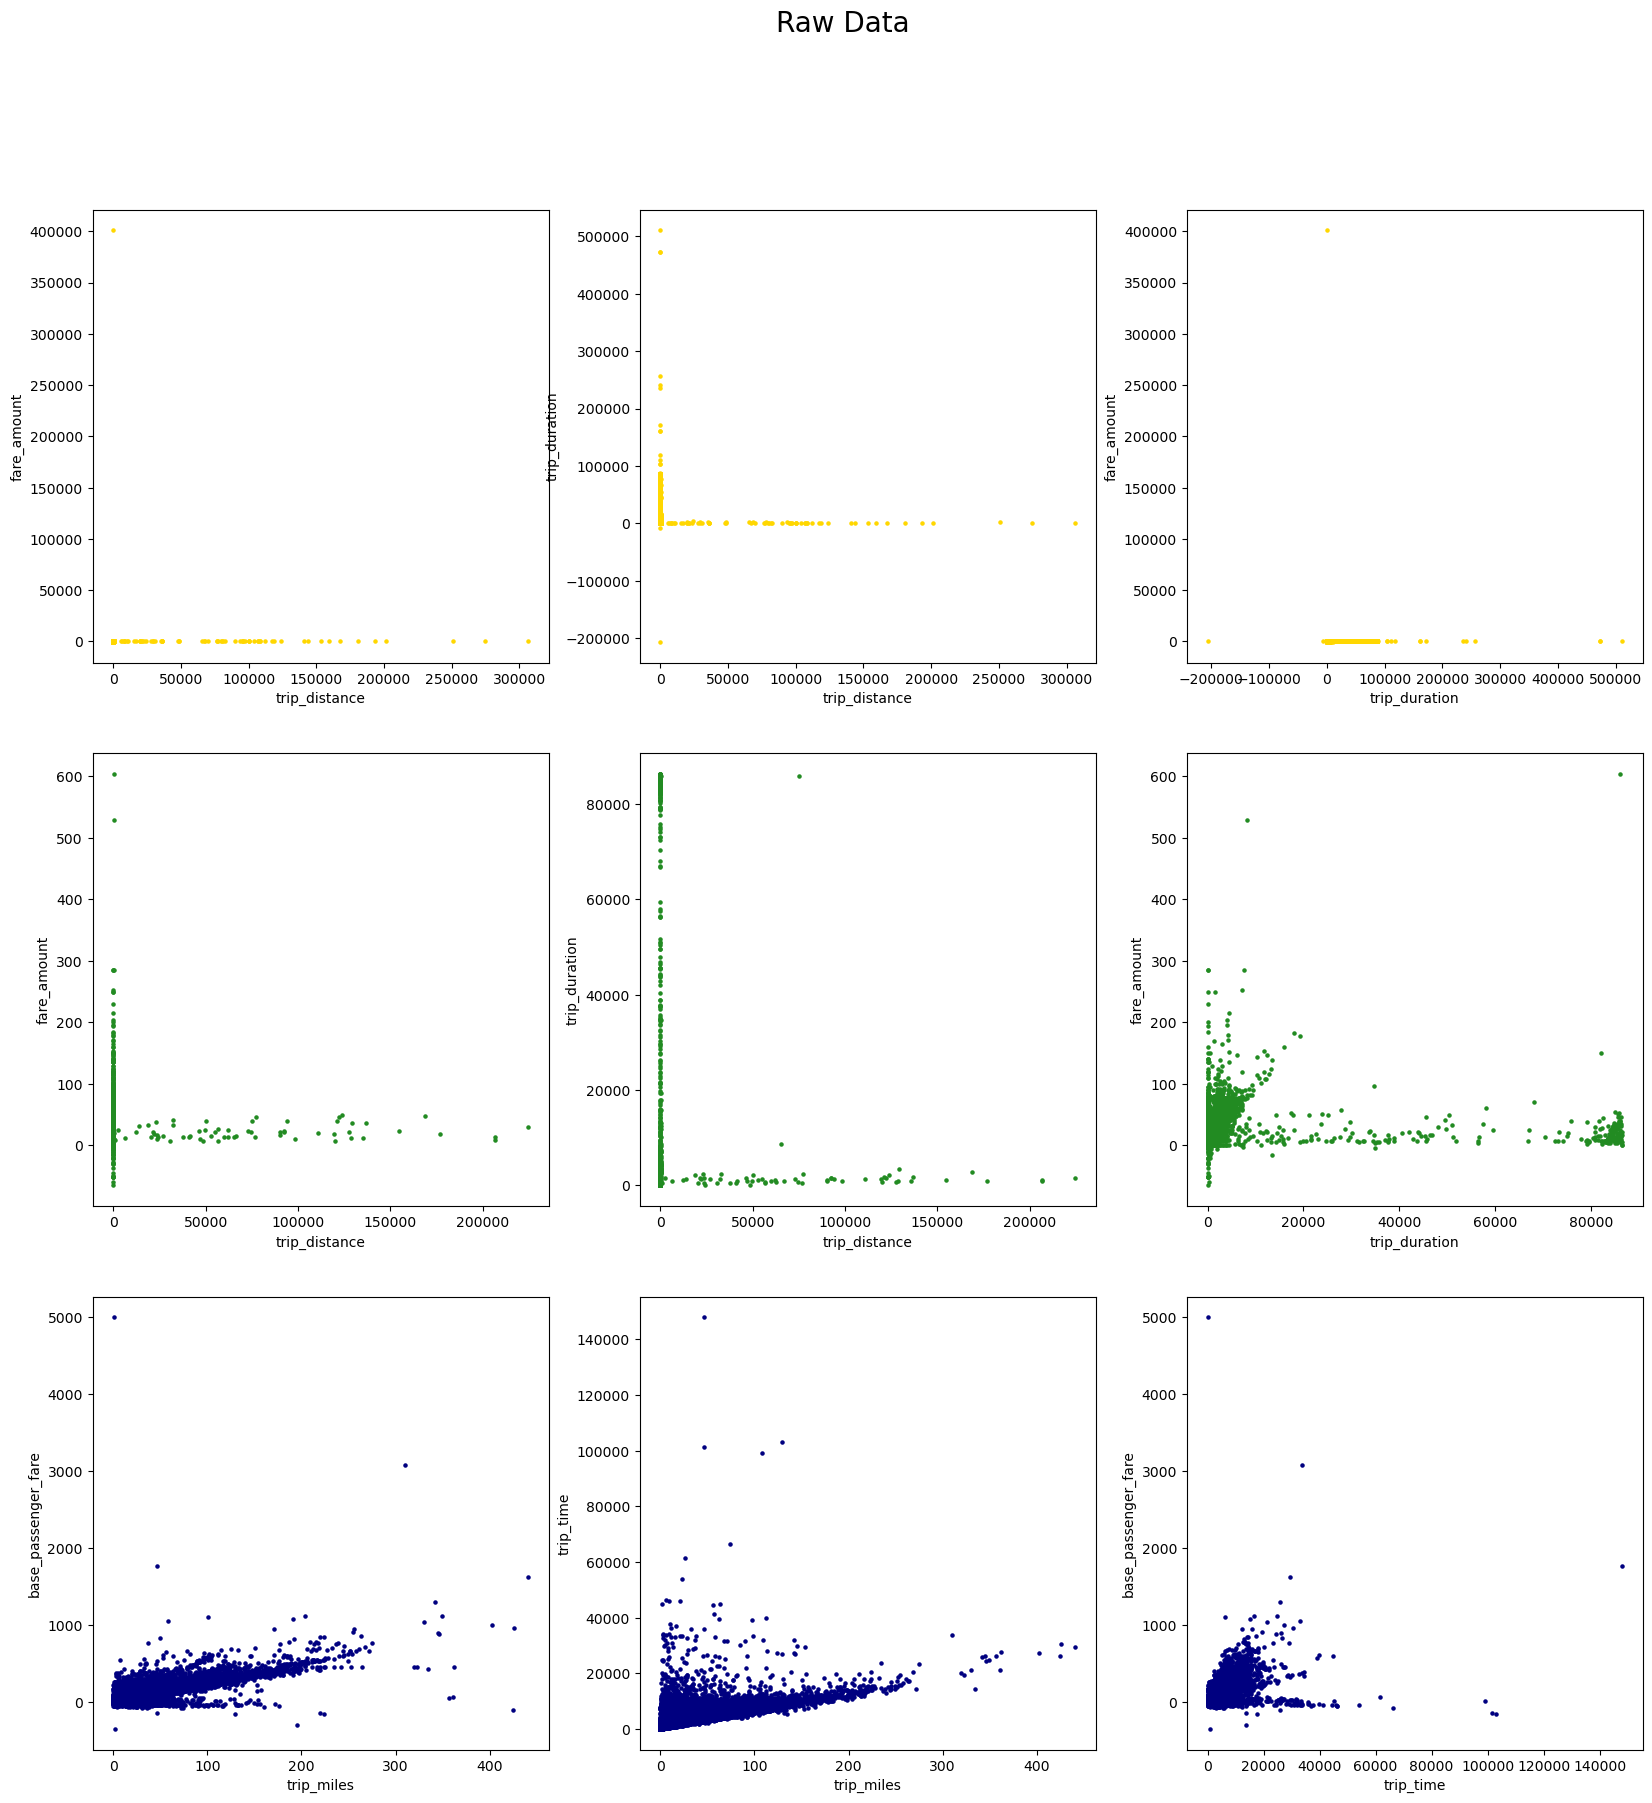

In [6]:
fig, ax = plt.subplots(3,3, figsize = (20,20))
fig.suptitle('Raw Data', fontsize = 20)

# plot raw data for yellow taxi over a few metrics
raw_ydata.plot.scatter(x = 'trip_distance', y = 'fare_amount', marker = '.', ax = ax[0][0], color = 'gold')
raw_ydata.plot.scatter(x = 'trip_distance', y = 'trip_duration', marker = '.', ax = ax[0][1], color = 'gold')
raw_ydata.plot.scatter(x = 'trip_duration', y = 'fare_amount', marker = '.', ax = ax[0][2], color = 'gold')

# plot raw data for green taxi over a few metrics
raw_gdata.plot.scatter(x = 'trip_distance', y = 'fare_amount', marker = '.', ax = ax[1][0], color = 'forestgreen')
raw_gdata.plot.scatter(x = 'trip_distance', y = 'trip_duration', marker = '.', ax = ax[1][1], color = 'forestgreen')
raw_gdata.plot.scatter(x = 'trip_duration', y = 'fare_amount', marker = '.', ax = ax[1][2], color = 'forestgreen')

# plot raw data for fhvhv taxi over a few metrics
raw_fhdata.plot.scatter(x = 'trip_miles', y = 'base_passenger_fare', marker = '.', ax = ax[2][0], color = 'navy')
raw_fhdata.plot.scatter(x = 'trip_miles', y = 'trip_time', marker = '.', ax = ax[2][1], color = 'navy')
raw_fhdata.plot.scatter(x = 'trip_time', y = 'base_passenger_fare', marker = '.', ax = ax[2][2], color = 'navy')

It is clear that some outliers are causing a few issues. For yellow and green taxis we have large trip durations and distances, which are skewing our data. We can also see one fare amount which is at 400000 dollars, which we don't want. We also see some negative fares for all the taxis, and negative trip durations for the yellow taxis, from dates that aren't January 2022, which is where impose_date() will be needed. We will now clean this data to note how effective our functions are.

### 2.2.2 Cleaned Data Plots

In [7]:
# clean the data for each taxi, using clean_data()
ydata = clean_data(raw_ydata)
gdata = clean_data(raw_gdata)
fhdata = clean_data(raw_fhdata)

# impose January 2022 on our data
ydata = impose_date(ydata, ['2022'], ['01'])
gdata = impose_date(gdata, ['2022'], ['01'])
fhdata = impose_date(fhdata, ['2022'], ['01'])

# remove outliers twice for each dataframe, using remove_outliers()
ydata = remove_outliers(remove_outliers(ydata))
gdata = remove_outliers(remove_outliers(gdata))
fhdata = remove_outliers(fhdata)

<AxesSubplot:xlabel='trip_time', ylabel='base_passenger_fare'>

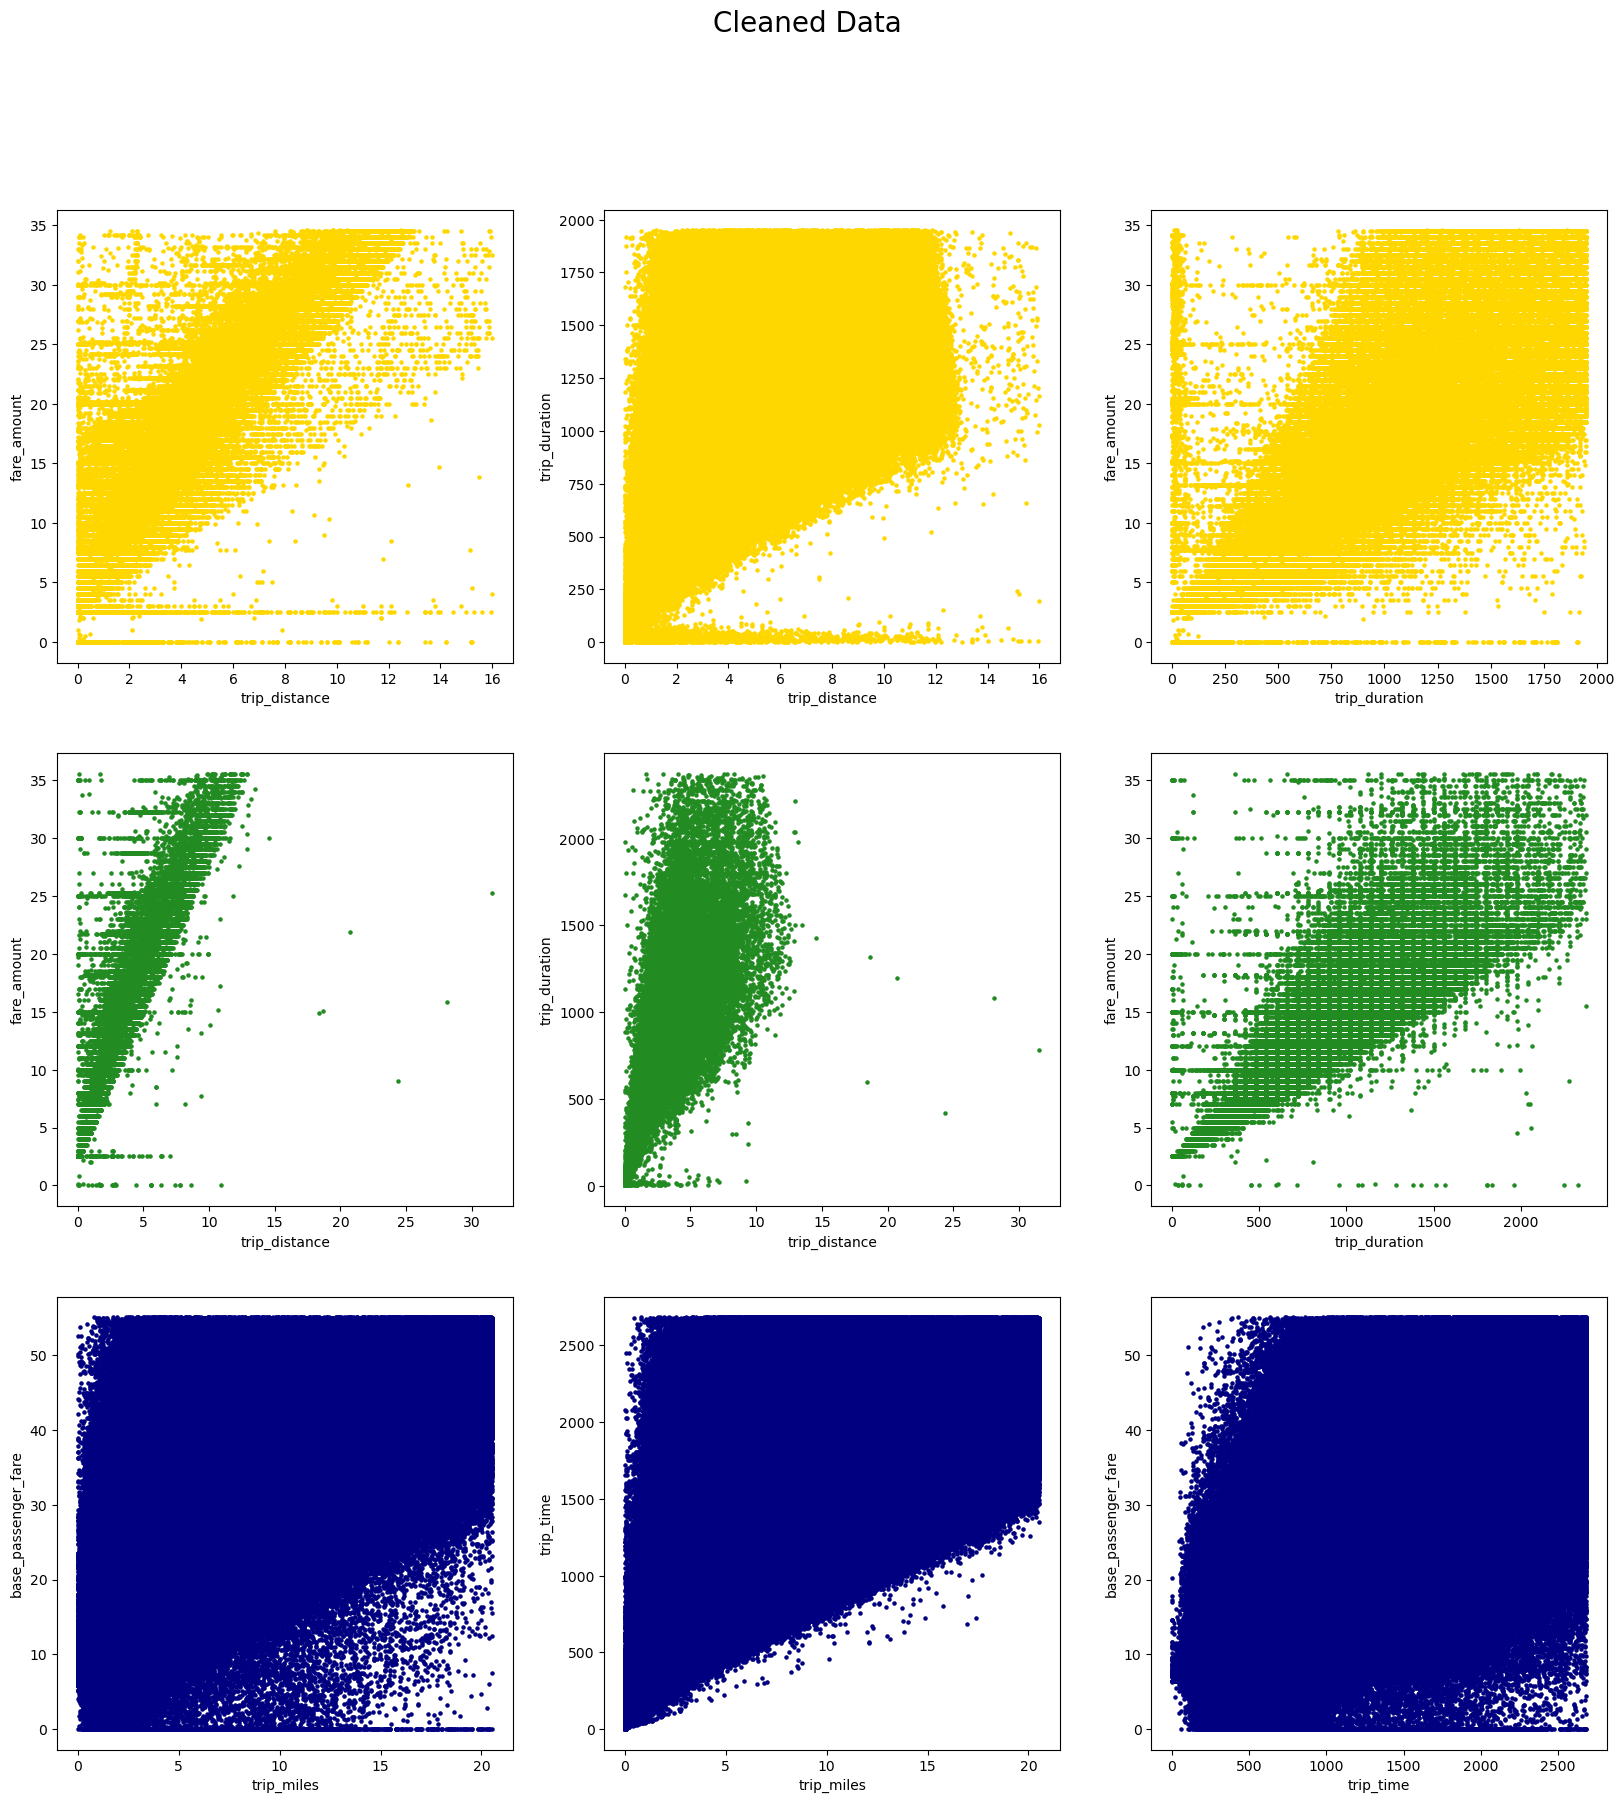

In [8]:
fig, ax = plt.subplots(3,3, figsize = (20,20))
fig.suptitle('Cleaned Data', fontsize = 20)

# plot clean data for yellow taxi over a few metrics
ydata.plot.scatter(x = 'trip_distance', y = 'fare_amount', marker = '.', ax = ax[0][0], color = 'gold')
ydata.plot.scatter(x = 'trip_distance', y = 'trip_duration', marker = '.', ax = ax[0][1], color = 'gold')
ydata.plot.scatter(x = 'trip_duration', y = 'fare_amount', marker = '.', ax = ax[0][2], color = 'gold')

# plot clean data for green taxi over a few metrics
gdata.plot.scatter(x = 'trip_distance', y = 'fare_amount', marker = '.', ax = ax[1][0], color = 'forestgreen')
gdata.plot.scatter(x = 'trip_distance', y = 'trip_duration', marker = '.', ax = ax[1][1], color = 'forestgreen')
gdata.plot.scatter(x = 'trip_duration', y = 'fare_amount', marker = '.', ax = ax[1][2], color = 'forestgreen')

# plot clean data for fhvhv taxi over a few metrics
fhdata.plot.scatter(x = 'trip_miles', y = 'base_passenger_fare', marker = '.', ax = ax[2][0], color = 'navy')
fhdata.plot.scatter(x = 'trip_miles', y = 'trip_time', marker = '.', ax = ax[2][1], color = 'navy')
fhdata.plot.scatter(x = 'trip_time', y = 'base_passenger_fare', marker = '.', ax = ax[2][2], color = 'navy')

We can see that largely all the outliers and un-realistic data points have been removed. We do however still see lot's of data points hanging around the 0 mark - these may be data points that lie just above 0, for instance someone might get in a taxi and immediately step back out, so the trip duration won't be very long. We will keep these for now as they still give us some insight. Note we have also allowed fare values to be 0, as this data still tells information about their journey that we may want.

We can also start making some qualitative analysis on this data. We see that fare generally increases with time and distance for and time increases with distance. These results are expected, but most importantly we confirm we are correctly importing and cleaning the data. 

# 3. Pick-ups and Drop-offs

In this section we we will analyse both the number of pick ups and the location of pick ups and drop offs for different taxi types. We arbitrarily pick January 2022 data is this is large and consistent with the rest of the report. We firstly import this data for columns relevant to this section, and clean it.

In [9]:
# get pick up and tip data for each taxi using get_taxi_data()
ydata = get_taxi_data('2022', '01', 'yellow', columns = ['PULocationID', 'DOLocationID', 'tip_amount', 'fare_amount', 
                                                 'trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'], save = True)
gdata = get_taxi_data('2022', '01', 'green', columns = ['PULocationID', 'DOLocationID', 'tip_amount', 'fare_amount', 
                                                 'trip_distance', 'lpep_pickup_datetime', 'lpep_dropoff_datetime'], save = True)
fhdata = get_taxi_data('2022', '01', 'fhvhv', columns = ['PULocationID', 'DOLocationID', 'tips', 'base_passenger_fare', 
                                                'trip_miles', 'trip_time', 'pickup_datetime', 'dropoff_datetime'], save = True)

# rename the files, for later use
os.replace('yellow_tripdata_2022-01.parquet', 'ydata.parquet')
os.replace('green_tripdata_2022-01.parquet', 'gdata.parquet')
os.replace('fhvhv_tripdata_2022-01.parquet', 'fhdata.parquet')

File not in current folder; trying to download data...
File not in current folder; trying to download data...
File not in current folder; trying to download data...


In [10]:
# clean the data for each taxi, using clean_data()
ydata = clean_data(ydata)
gdata = clean_data(gdata)
fhdata = clean_data(fhdata)

# impose January 2022 on our data
ydata = impose_date(ydata, ['2022'], ['01'])
gdata = impose_date(gdata, ['2022'], ['01'])
fhdata = impose_date(fhdata, ['2022'], ['01'])

# remove outliers twice for each dataframe, using remove_outliers().
ydata = remove_outliers(remove_outliers(ydata))
gdata = remove_outliers(remove_outliers(gdata))
fhdata = remove_outliers(remove_outliers(fhdata))

## 3.1 Weekly pick-ups and drop-offs
To start analysing the taxi pick-ups we first break-down pick-ups into the average number of pick-ups per day and hour of the day. We do this by defining weeklybreakdown() which returns two dataframes of all 168 hours in the week. One containing the count of the number of times each hour of the week appears in the given data and one with the mean of some metric at each hour of the week, e.g. 'tip_amount' would give the average number of tips at each hour of an average week. We then use this function to plot what an average week of pick-ups looked like in January 2022. Note: Drop-offs are equivalent to pick-ups here, so we only look at pick-ups.

In [11]:
def weeklybreakdown(df, col = 'count'):
    '''Given a dataframe containing pick-up times this function splits the data up into every hour of the week in two 24x7 dataframes. 
    These hour boxes contain values which are the count and mean of some metric (e.g. 'tip_amount') over the data's timescale. The mean
    will be the average value of the metric for an average week in the dataframe, but the count is just the number of times each hour
    of week appears in the given dataframe.
    
    Parameters:
        df (pd.DataFrame):               Pandas dataframe we would like to split up.
        col (DataFrame header, string):  Metric to assign to hour boxes, defaulting to 'count', which will give a mean of 1 at every hour.
        
    Returns:
        dfcount (pd.DataFrame):  24x7 Dataframe of number of datapoints that appear at an hour of the week 
        dfmean (pd.DataFrame): 24x7 Dataframe of average values over an average week in the dataframe
    
    '''

    # rename pick-up time columns for each taxi type, so we can apply this function to any of the taxis
    df = df.rename(columns = {'tpep_pickup_datetime': 'pickuptime', 'lpep_pickup_datetime': 'pickuptime', 'pickup_datetime': 'pickuptime'})
    
    # make sure we actually have a pick-up time, or we can't split the data up via timestamp
    assert 'pickuptime' in df.columns, 'Data needs a pick-up time column'
    
    # create two 24 x 7 empty dataframes which correspond to each hour of the day for each day of the week 
    dfcount = pd.DataFrame(columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                         ,index = range(24))
    dfmean = dfcount.copy()
    
    # create a count column to count entries at each hour box 
    df['count'] = 1
        
    # create a weekday and hour column in each of our dataframes
    df['weekday'] = df['pickuptime'].dt.day_name()
    df['hour'] = df['pickuptime'].dt.hour
    
    # loop over every weekday Monday - Sunday
    for weekday in dfcount.columns:
        
        # pick values from our dataframe that have pickups on that weekday
        dfweekday = df[df['weekday'] == weekday]
        
        # count the number of times each hour for that weekday appears in the dataframe
        dfcount[weekday] = dfweekday.groupby('hour')['count'].sum()
        
        # find the mean value of the metric for each hour of the week 
        dfmean[weekday] = dfweekday.groupby('hour')[col].mean()
            
    return dfcount, dfmean

<AxesSubplot:title={'center':'Number of for-hire taxi pickups over an average week in January 2022'}>

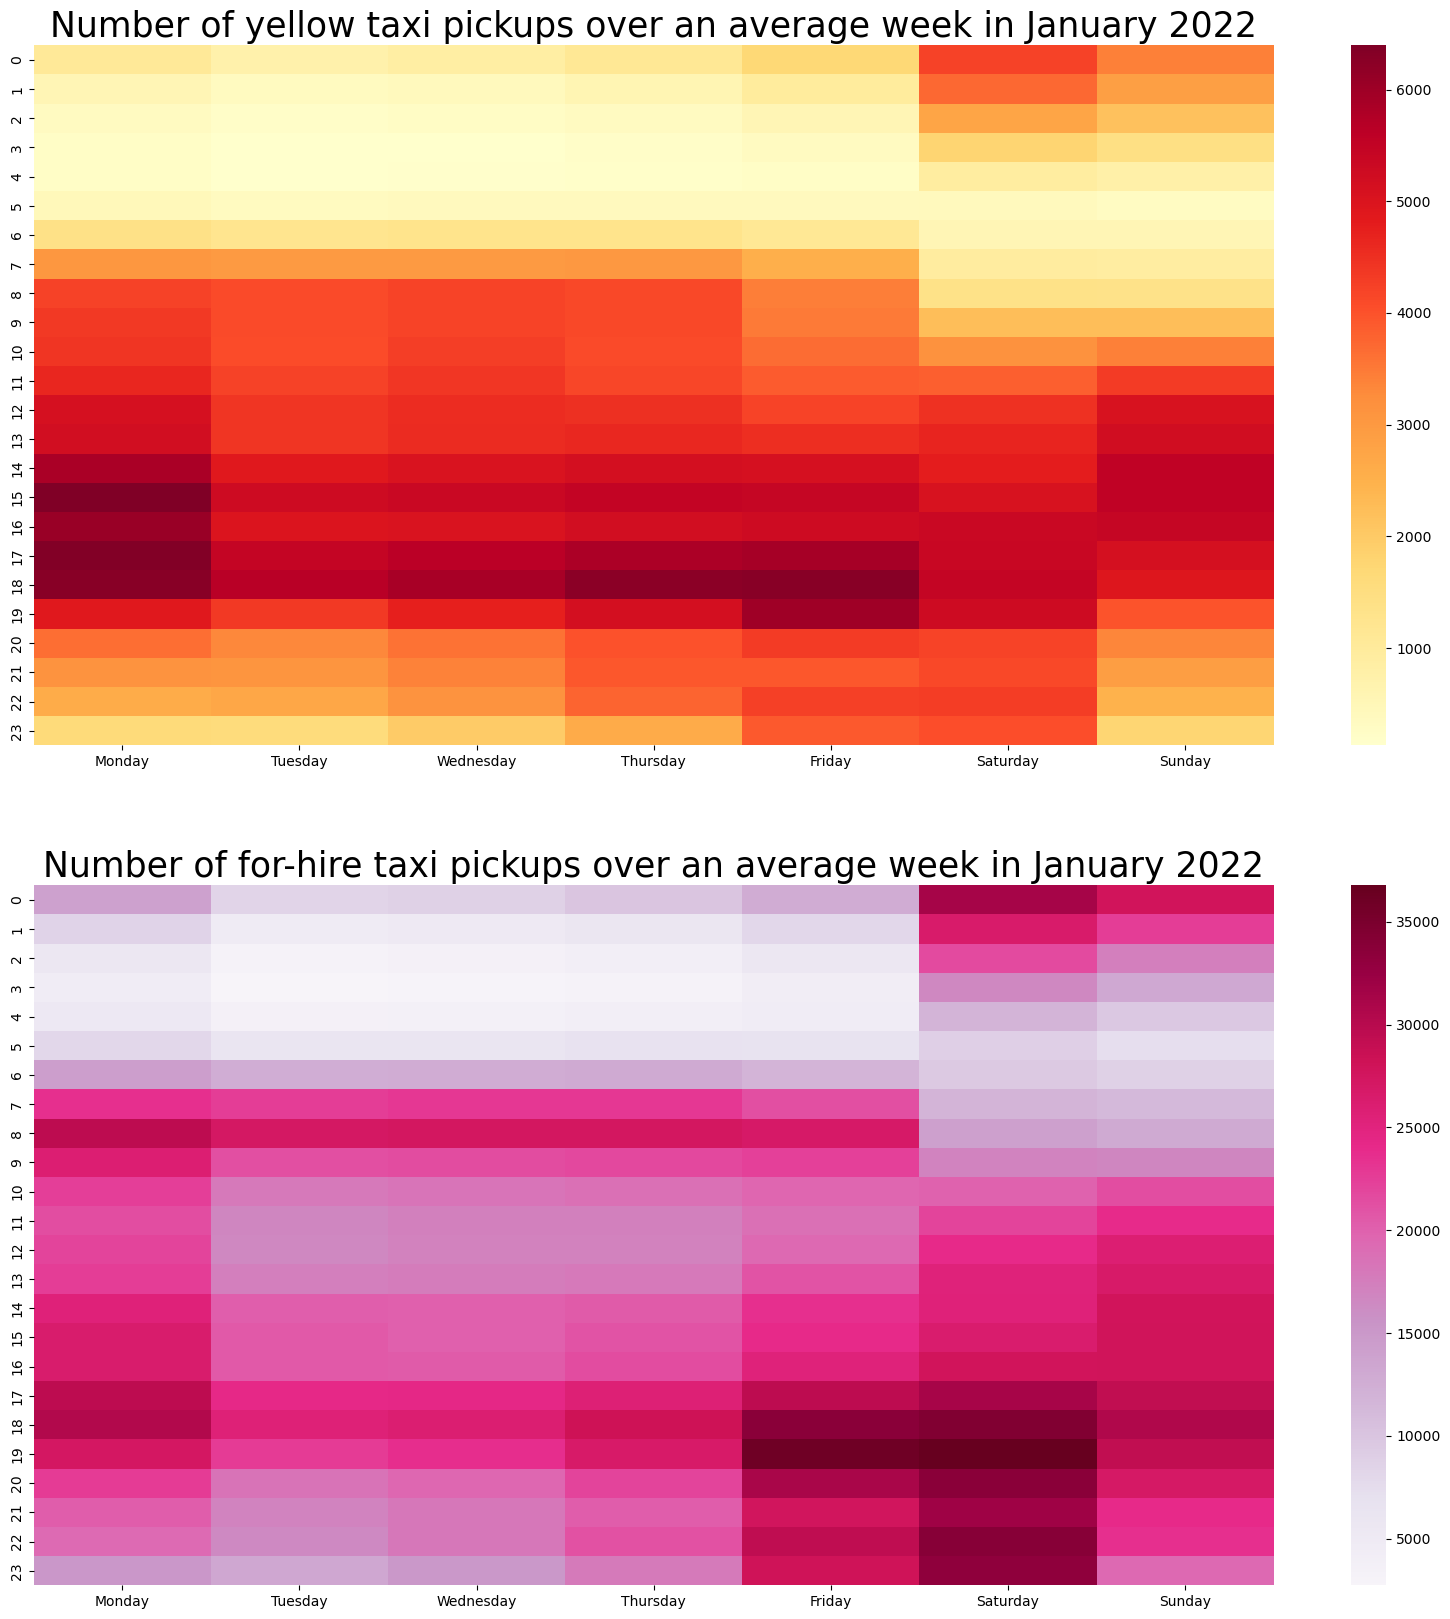

In [12]:
# find the number of pick-ups at each hour of the day for Jan 2022. We divide by four to give the number of pick-ups per week.
y_weekly_pickups = weeklybreakdown(ydata.copy())[0] / 4
fh_weekly_pickups = weeklybreakdown(fhdata.copy())[0] / 4

# create a subplot to compare yellow taxis and for-hire taxis 
figweekPU, ax = plt.subplots(2,1, figsize=(20, 20))
ax[0].set_title('Number of yellow taxi pickups over an average week in January 2022', fontsize = 25)
ax[1].set_title('Number of for-hire taxi pickups over an average week in January 2022', fontsize = 25)

# create colorbar for the yellow taxis 
color = 'YlOrRd'
vmin, vmax = 0, y_weekly_pickups.max().max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# plot heatmap of number of yellow taxi pick-ups over an average week in Jan 2022
sns.heatmap(y_weekly_pickups, cmap = color, ax = ax[0])

# create colorbar for the for-hire taxis 
color = 'PuRd'
vmin, vmax = 0, fh_weekly_pickups.max().max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# plot heatmap of number of yellow taxi pick-ups over an average week in Jan 2022
sns.heatmap(fh_weekly_pickups, cmap = color, ax = ax[1])

There are a few results we can gleam from these graphs:
- Darker sections represent when both taxi types are busiest and lighter sections when they are less busy. As expected the majority of taxi pickups occur 7am - 11pm, and the lesser busy times are at night.
- Generally speaking the most dense times for yellow taxi pickups are from 5pm to 8pm Monday to Friday, which is when we would expect rush hour to be.
- Both taxi types see an increase in pick ups on Friday and Saturday Evening and early Saturday and Sunday morning, but for-hire vehicles get relatively more busy compared to the rest of the week at these times. This is likely due to people using for-hire vehicles to travel around New York's nightlife.
- We also see that for-hire vehicles have a weekday spike at about 8am, when people heading to work.
- More people are using for-hire taxis - if we take a look at the scale, for-hire taxis have a maximum number of pick-ups of about 35000 per day, whereas for yellow taxis this is about 6000. Whether people are using these taxis more in the same locations or these taxis are being used over a larger area is yet to be determine, but gives us motivation for section 3.2.

## 3.2 Pick-up and Drop-off Locations
Now we know the times when people are getting taxis, we would like to know where they are getting the taxis from. We will use geopandas to plot a choropleth map of pick-up and drop-off locations, but for this we need to create a function to take the number of pick-ups or drop-offs or other metrics and map them to a region which we can plot. We will count how many pick-ups or drop-offs we have per ID and merge this with a shapefile we can plot. We will use the shapefile available on the NYC website [3].

In [13]:
# get and taxi zones shapefile from [3]
taxi_zones = gpd.read_file('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip')

# [3]
# NEW YORK TAXI & LIMOUSINE COMISSION, 
# Taxi Zone Shapefile
# UR: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# Last Accessed On: 05/12/2022

In [14]:
def choropleth(df, ID = 'PULocationID'):
    '''Generates a choropleth map of new york city taxi zones for pick-ups or drop-offs (ID).
    
    Parameters:
        df (pd.DataFrame): DataFrame we wish to create a choropleth out of 
        ID:                Name of pick-up or drop-off column, either 'PULocationID' (default) or 'DOLocationID'
        
    Returns:
        df (pd.DataFrame): DataFrame containing a count of pick-ups or drop-offs and geometries of the taxi zones
    '''
    
    # create a count column to count pick-ups or drop-offs
    df['count'] = 1
    
    # sum the values contained in each taxi-zone, we can use these to plot different metrics, but importantly we sum 'count'
    sumbyID = df.groupby(ID).sum()
    
    # merge counted dataframe with the shapefile of taxi zone geometries
    df = taxi_zones.set_index('LocationID').join(sumbyID)

    # make sure any NaN value is delt with 
    df = df.fillna(0)

    return df

### 3.2.1 Pick-up and drop-off maps

<AxesSubplot:title={'center':'Number of For-Hire Taxi Dropoffs, January 2022'}>

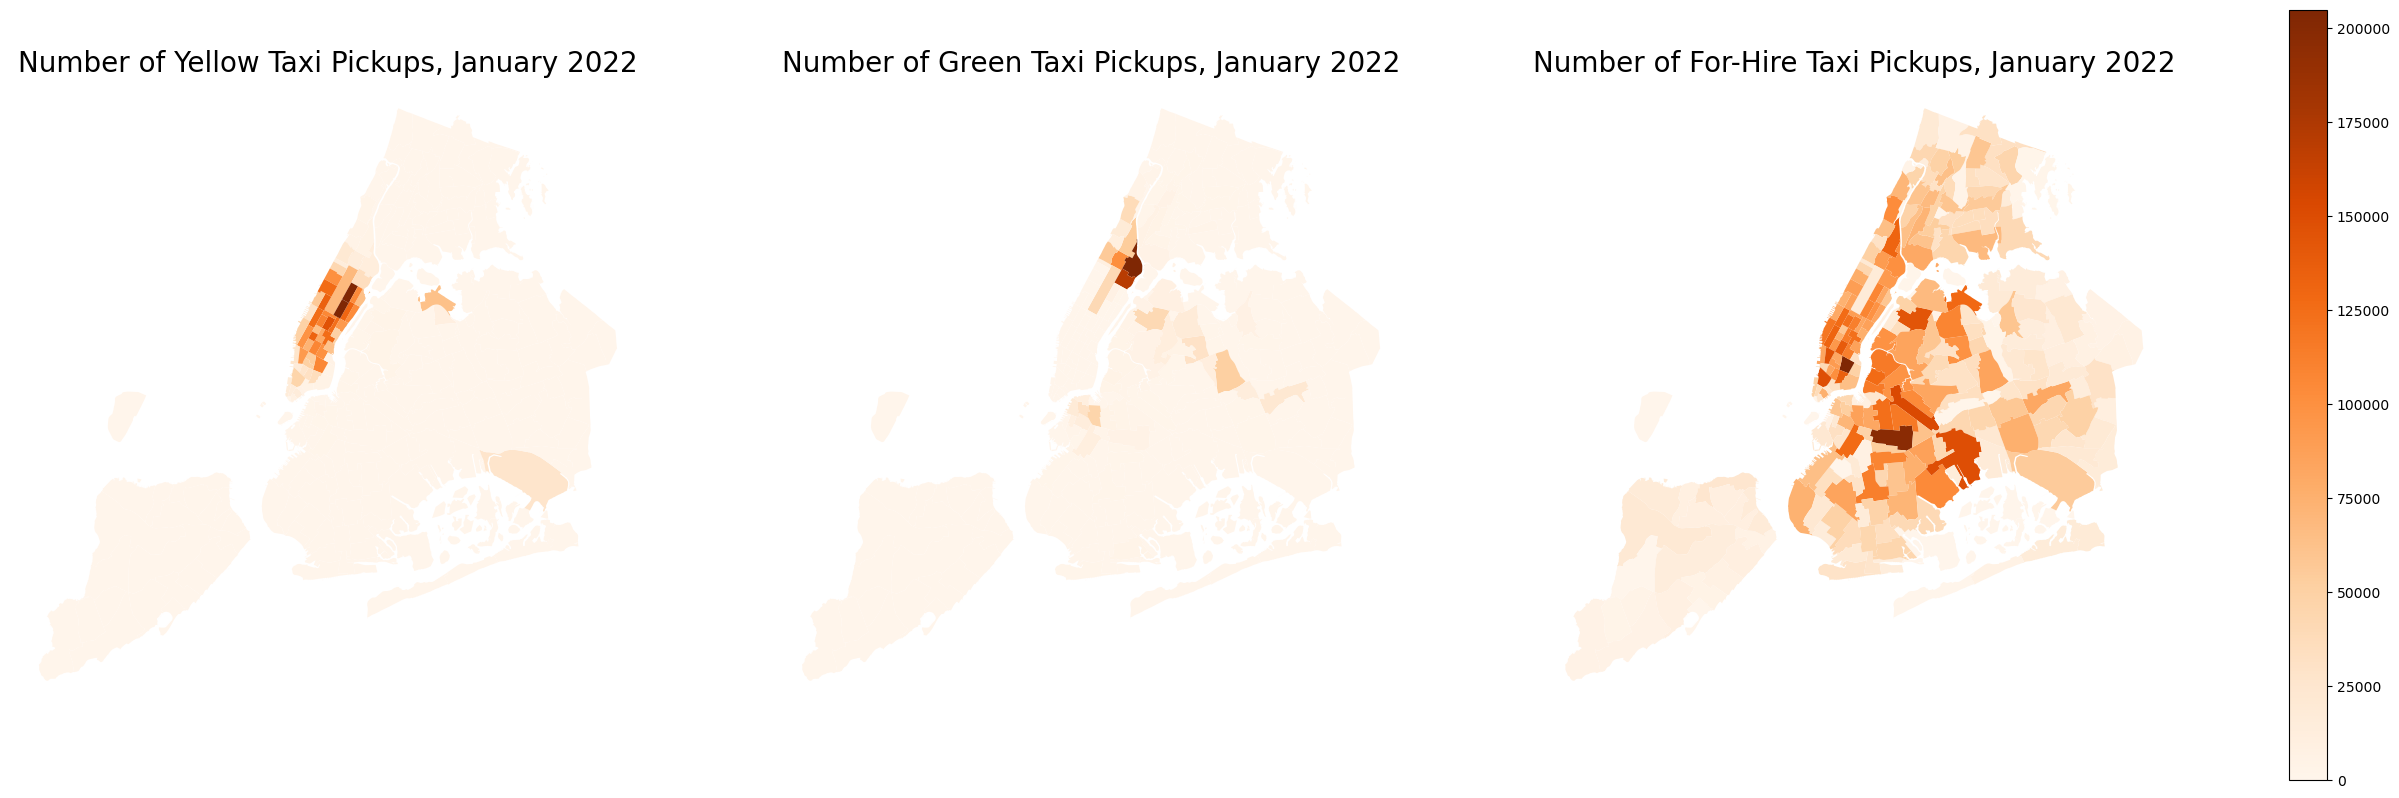

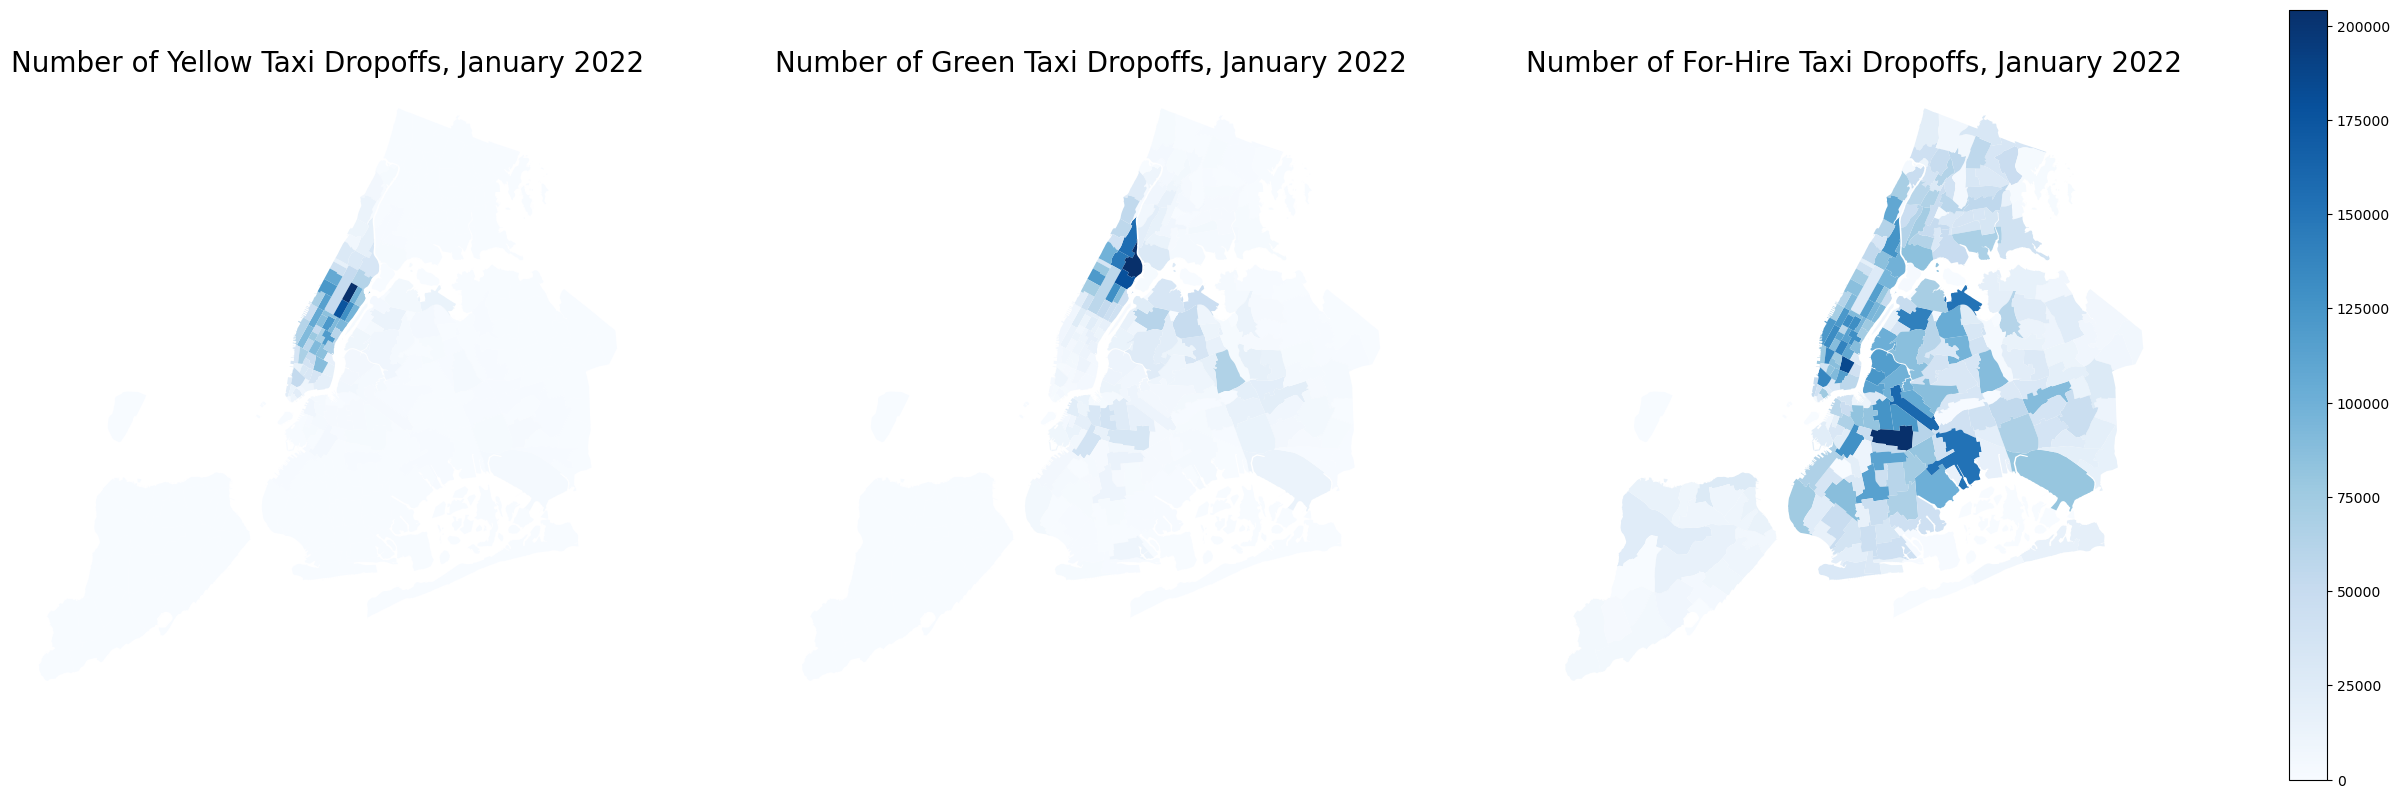

In [15]:
#### PICK UPS #####

# generate choropleth graphs for pick-ups
y_PU_map = choropleth(ydata)
g_PU_map = choropleth(gdata)
fh_PU_map = choropleth(fhdata)

# create and label subplots for each taxi type
figpickups, ax = plt.subplots(1,3, figsize=(30, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Number of Yellow Taxi Pickups, January 2022', fontsize = 20)
ax[1].set_title('Number of Green Taxi Pickups, January 2022', fontsize = 20)
ax[2].set_title('Number of For-Hire Taxi Pickups, January 2022', fontsize = 20)

# create colorbar, which will encompass every pick-up map 
PUcolor = 'Oranges'
vmin, vmax = 0, max(y_PU_map['count'].max(), g_PU_map['count'].max(), fh_PU_map['count'].max())
smPU = plt.cm.ScalarMappable(cmap=PUcolor, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figpickups.colorbar(smPU, ax = ax, fraction = .02)

# plot choropleths
y_PU_map.plot('count', cmap=PUcolor, linewidth=0.8, ax=ax[0])
g_PU_map.plot('count', cmap=PUcolor, linewidth=0.8, ax=ax[1])
fh_PU_map.plot('count', cmap=PUcolor, linewidth=0.8, ax=ax[2])

#### DROP OFFS ####
y_DO_map = choropleth(ydata, ID = 'DOLocationID')
g_DO_map = choropleth(gdata, ID = 'DOLocationID')
fh_DO_map = choropleth(fhdata, ID = 'DOLocationID')

# create and label subplots for each taxi type
figdropoffs, ax = plt.subplots(1,3, figsize=(30, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Number of Yellow Taxi Dropoffs, January 2022', fontsize = 20)
ax[1].set_title('Number of Green Taxi Dropoffs, January 2022', fontsize = 20)
ax[2].set_title('Number of For-Hire Taxi Dropoffs, January 2022', fontsize = 20)

# create colorbar, which will encompass every drop-off map 
DOcolor = 'Blues'
vmin, vmax = 0, max(y_DO_map['count'].max(), g_DO_map['count'].max(), fh_DO_map['count'].max())
smDO = plt.cm.ScalarMappable(cmap=DOcolor, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figpickups.colorbar(smDO, ax = ax, fraction = .02)

# plot choropleths
y_DO_map.plot('count', cmap=DOcolor, linewidth=0.8, ax=ax[0])
g_DO_map.plot('count', cmap=DOcolor, linewidth=0.8, ax=ax[1])
fh_DO_map.plot('count', cmap=DOcolor, linewidth=0.8, ax=ax[2])

From these we can yield some results:
- We see that yellow taxis only really pick-up from airports and Manhattan and specifically pick-up the most next to central park where the majority of tourist destinations are, this is expected. We see that they drop off primarily to Manhattan and not airports. 

- We see that green taxis fill the remaining gap in northern Manhattan where yellow taxis don't visit, as well as some areas outside of manhattan, but not airports. This is because they can't go in yellow taxi zones. The green taxi drop-off range is a bit bigger and more spread out than yellows', and they are dropping off to the airport more than yellow taxis. 

- Thirdly, we see that for-hire vehicles pick up and drop-off to pretty much everywhere but more toward the centre of the city. We see for-hire taxis are used more widely and mroe than the other types of taxis, even if yellow taxis are the taxis people think of in the traditional sense. 

- For all the taxis we see that Staten-Island is largely ignored, maybe due to tolls, or less of a need for taxis. More analysis would be needed into this.

- Finally, we see that pick-ups and drop-offs are largely the same for all three taxis, maybe because people are travelling to and back from certain regions via taxis. 

# 4 Journey analysis
In this section we analyse the journeys taxis make accross the city, again using January 2022 as our primary data.

In [16]:
# import the pickup and dropoff locations for the yellow and for-hire taxis (January 2022)
journeys_yellow_raw = get_taxi_data('2022', '01', 'yellow', columns = ['PULocationID', 'DOLocationID'], save=False)
journeys_fhvhv_raw = get_taxi_data('2022', '01', 'fhvhv', columns = ['PULocationID', 'DOLocationID'], save=False)

File not in current folder; trying to download data...
File not in current folder; trying to download data...


## 4.1 Frequent Journeys, inc. Airports

In [17]:
# read the taxi zone lookup file
borough_lookup = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv', index_col='LocationID')

# get the frequency of trips to and from each zone
journeys_yellow = journeys_yellow_raw.groupby(['PULocationID','DOLocationID']).size().sort_values(ascending=False)
journeys_yellow = journeys_yellow.reset_index(level=['PULocationID','DOLocationID'])

# add columns indicating the corresponding borough using the lookup file
journeys_yellow['boro_PU'] = borough_lookup['Borough'].iloc[journeys_yellow['PULocationID']-1].reset_index(drop=True)
journeys_yellow['boro_DO'] = borough_lookup['Borough'].iloc[journeys_yellow['DOLocationID']-1].reset_index(drop=True)

# rename the frequency column
journeys_yellow = journeys_yellow.rename(columns={0: 'frequency'})

# do the same for FHVH
journeys_fhvhv = journeys_fhvhv_raw.groupby(['PULocationID','DOLocationID']).size().sort_values(ascending=False)
journeys_fhvhv = journeys_fhvhv.reset_index(level=['PULocationID','DOLocationID'])
journeys_fhvhv['boro_PU'] = borough_lookup['Borough'].iloc[journeys_fhvhv['PULocationID']-1].reset_index(drop=True)
journeys_fhvhv['boro_DO'] = borough_lookup['Borough'].iloc[journeys_fhvhv['DOLocationID']-1].reset_index(drop=True)
journeys_fhvhv = journeys_fhvhv.rename(columns={0: 'frequency'})

# rename columns for easier readability
journeys_yellow.columns = ['Pick-up Zone', 'Drop-Off Zone', 'Frequency', 'Pick-Up Borough', 'Drop-Off Borough']
journeys_fhvhv.columns = ['Pick-up Zone', 'Drop-Off Zone', 'Frequency', 'Pick-Up Borough', 'Drop-Off Borough']

# display the 10 most frequent trips
display_side_by_side(journeys_yellow.head(10), journeys_fhvhv.head(10), titles=['Yellow', 'FHVHV'])


,Pick-up Zone,Drop-Off Zone,Frequency,Pick-Up Borough,Drop-Off Borough
0,237,236,18749,Manhattan,Manhattan
1,236,237,16200,Manhattan,Manhattan
2,236,236,13871,Manhattan,Manhattan
3,237,237,12149,Manhattan,Manhattan
4,264,264,10811,Unknown,Unknown
5,141,236,7712,Manhattan,Manhattan
6,239,238,7636,Manhattan,Manhattan
7,239,142,6997,Manhattan,Manhattan
8,142,239,6955,Manhattan,Manhattan
9,263,141,6897,Manhattan,Manhattan


The left table above shows that the most frequent yellow taxi rides took place in Manhattan in and between zones 236 and 237. This is the area east of Central Park, that has already been highlighted dark in the yellow taxi choropleth map. 

When observing the right table it is evident that For-Hire taxis are mostly used outside of Manhattan. 

However, these conclusions could already be made when analysing the choropleth maps. To get a better understanding on how both taxi types are used to commute in between two boroughs, the intraborough trips need to be eliminated in the next step. Additionally, the trips from and to the three main New York airports, will not be considered as we try to identify the interborough traffic having the borough as a destination and not a flight to somewhere else.

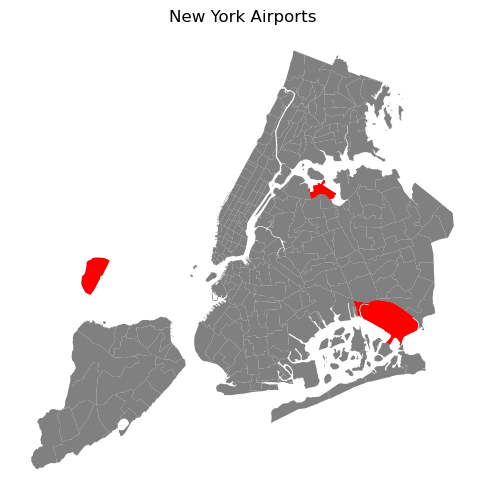

In [18]:
# read new york shapefile into geodataframe
ny = gpd.read_file("https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip")

# get airports
ny_airports = ny[ny['zone'].str.contains('airport', case=False)]

# get airport location IDs
airports_id = list(ny_airports['LocationID'])

# plot airports to be excluded
fig, ax = plt.subplots(figsize = (6,6)) 
ny.plot(ax=ax, color='grey')
ny_airports.plot(color='red', ax=ax)

ax.set_title('New York Airports')
ax.axis('off')

plt.show()

# define a function to remove trips from and to airports
def remove_airport_trips(gdf):
    '''
    Removes the trips that start or end at one of the three main New York airports from the given 
    (Geo-)dataframe and returns the cleaned one.
    '''
    if 'Pick-up Zone' in gdf.columns and 'Drop-Off Zone' in journeys_yellow.columns:
        for i in range(3):
            gdf = gdf[gdf['Pick-up Zone'] != airports_id[i]]
            gdf = gdf[gdf['Drop-Off Zone'] != airports_id[i]] 
    elif 'PULocationID' in gdf.columns and 'DOLocationID' in journeys_yellow.columns:
        for i in range(3):
            gdf = gdf[gdf['PULocationID'] != airports_id[i]]
            gdf = gdf[gdf['DOLocationID'] != airports_id[i]] 
    else:
        raise ValueError('The given dataframe does not contain a readable name for the zones')

    return gdf


The figure below shows the zones containing the three main New York airports on a map. Taxi rides to and from these zones will be excluded for the reason mentioned above.

## 4.2 Frequent journeys, excl. airports
We now perform the same analysis as before, but with the removal of airports. 

In [19]:
# remove journeys in the same borough and travels to and from unknown boroughs
interboro_yellow = journeys_yellow[journeys_yellow['Pick-Up Borough'] != journeys_yellow['Drop-Off Borough']]
interboro_yellow = interboro_yellow[interboro_yellow['Pick-Up Borough'] != 'Unknown']
interboro_yellow = interboro_yellow[interboro_yellow['Drop-Off Borough'] != 'Unknown']

# the same for fhvhv
interboro_fhvhv = journeys_fhvhv[journeys_fhvhv['Pick-Up Borough'] != journeys_fhvhv['Drop-Off Borough']]
interboro_fhvhv = interboro_fhvhv[interboro_fhvhv['Pick-Up Borough'] != 'Unknown']
interboro_fhvhv = interboro_fhvhv[interboro_fhvhv['Drop-Off Borough'] != 'Unknown']

# remove journeys to and from airports
interboro_yellow, interboro_fhvhv = remove_airport_trips(interboro_yellow), remove_airport_trips(interboro_fhvhv)

# reset indices
interboro_yellow = interboro_yellow.reset_index(drop=True)
interboro_fhvhv = interboro_fhvhv.reset_index(drop=True)


display_side_by_side(interboro_yellow.head(10), interboro_fhvhv.head(10), titles=['Yellow', 'FHVHV'])


,Pick-up Zone,Drop-Off Zone,Frequency,Pick-Up Borough,Drop-Off Borough
0,141,7,382,Manhattan,Queens
1,148,256,342,Manhattan,Brooklyn
2,70,230,338,Queens,Manhattan
3,79,256,330,Manhattan,Brooklyn
4,48,7,301,Manhattan,Queens
5,230,7,295,Manhattan,Queens
6,237,7,292,Manhattan,Queens
7,229,7,281,Manhattan,Queens
8,162,7,279,Manhattan,Queens
9,79,255,278,Manhattan,Brooklyn


The tables above show the ten most frequent zone combinations for interborough taxi rides excluding airports. It is apparent that most yellow taxi rides start in Manhattan while the For-Hire taxis have a wider variety in pick-up locations, confirming our findings above. 

Additionally, we can observe that most taxi rides do not leave one borough when comparing these tables to the tables above (most frequent zone combination 382 to 18,742 for yellow and 9781 to 48,224 for FHVHV)

Drop-Off Borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
Pick-Up Borough,,,,,
Bronx,NaN,273.0,1222.0,335.0,9.0
Brooklyn,313.0,NaN,5063.0,942.0,24.0
Manhattan,9471.0,47733.0,NaN,31466.0,258.0
Queens,671.0,2342.0,10907.0,NaN,36.0
Staten Island,5.0,30.0,33.0,38.0,NaN
Drop-Off Borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
Pick-Up Borough,,,,,
Bronx,NaN,24009.0,311572.0,43273.0,511.0
Brooklyn,25072.0,NaN,454260.0,259637.0,15553.0


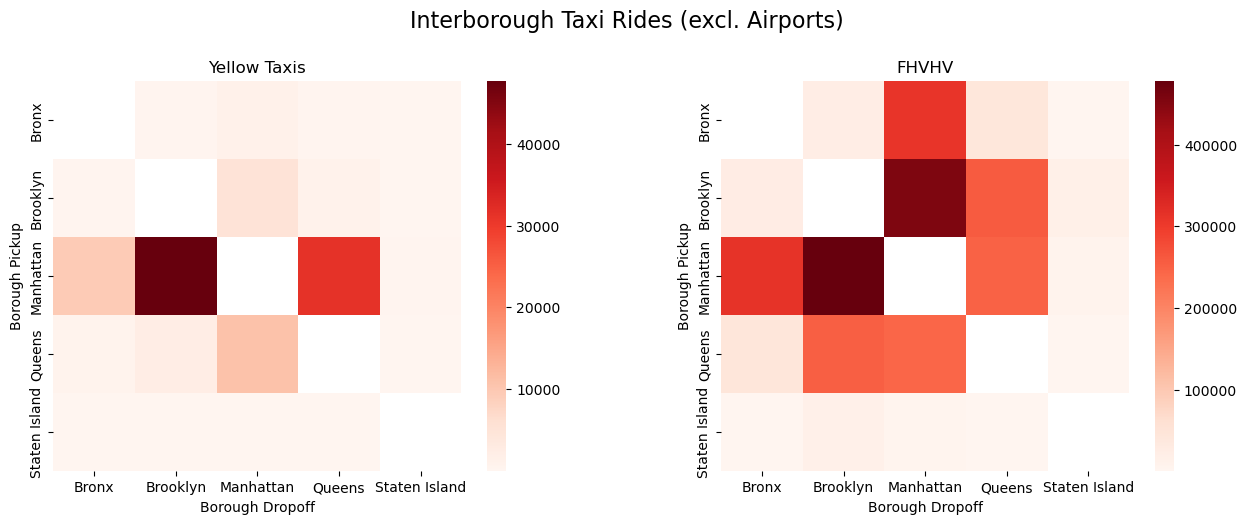

In [20]:
# use a pivot table to rearrange tables in a way that shows the frequency of trips from one borough to another
heatmap_interboro_yellow = interboro_yellow.pivot_table(index='Pick-Up Borough', columns='Drop-Off Borough', values='Frequency', aggfunc=sum)
heatmap_interboro_fhvhv = interboro_fhvhv.pivot_table(index='Pick-Up Borough', columns='Drop-Off Borough', values='Frequency', aggfunc=sum)

# display dataframes
display_side_by_side(heatmap_interboro_yellow, heatmap_interboro_fhvhv, titles=['Yellow', 'FHVHV'])


# create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (14,6)) 

# plot two heatmaps
sns.heatmap(data=heatmap_interboro_yellow, cmap="Reds", annot=False, ax=ax[0])
sns.heatmap(data=heatmap_interboro_fhvhv, cmap="Reds", annot=False, ax=ax[1])

plt.tight_layout(pad=6, w_pad=8)

for j in range(2):
    ax[j].set_xlabel('Borough Dropoff')
    ax[j].set_ylabel('Borough Pickup')

ax[0].set_title('Yellow Taxis')
ax[1].set_title('FHVHV')


fig.suptitle('Interborough Taxi Rides (excl. Airports)', fontsize=16)

plt.show()

The tables and corresponding heatmaps above show the frequency of interborough taxi rides for each borough combination. Again, it can be confirmed that yellow taxis mostly pick up their customers in Manhattan. If these rides do not also end in Manhattan or at an airport, they mostly drive to Brooklyn or Queens. The second most popular pickup spot is be Queens (followed by Brooklyn) and customers seem to mostly go back to Manhattan.

For-Hire vehicles are mostly used to commute between Brooklyn and Manhattan, but also between Manhattan and Bronx, Manhattan and Queens, as well as Bronx and Brooklyn. It is also apparent, that the heatmap of FHVHV is far more symmetric than the one for yellow taxis, indicating a more equal traffic into and out of each borough. It also emphasizes that For-Hire taxis can more easily be called in every borough while most available yellow taxis are found in Manhattan. 

Let's take a look at these interborough taxi rides on a map:

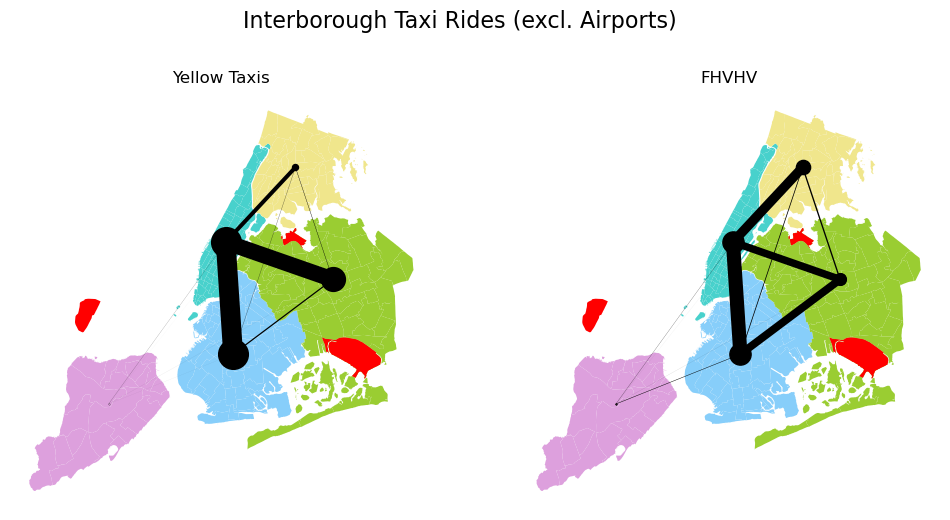

In [21]:
# create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (12,6)) 

colorlist = ['mediumturquoise', 'lightskyblue', 'yellowgreen', 'khaki',  'plum']

# estimate center points of the boroughs
manhattan = [992000, 220000]
brooklyn = [995000, 175000]
queens = [1035000, 205000]
bronx = [1020000, 250000]
staten = [945000, 155000]

# create a dictionary with the names and the coordinates
boros_dict = {'Manhattan': manhattan, 'Brooklyn': brooklyn, 'Queens': queens, 'Bronx': bronx, 'Staten Island': staten}

# create lists for the total number of trips and the two heatmap dataframes
totaltrips = [heatmap_interboro_yellow.sum().sum(), heatmap_interboro_fhvhv.sum().sum()]
heatmaps = [heatmap_interboro_yellow, heatmap_interboro_fhvhv]

# do the same thing for the two different taxi types
for j in range(2):
    
    # plot a map of New York with each borough coloured differently
    for i in range(len(boros_dict)):
        ny[ny['borough']==list(boros_dict.keys())[i]].plot(color=colorlist[i], ax=ax[j])
    
    # mark the excluded NY airports in red
    ny_airports.plot(color='red', ax=ax[j])
    
    ax[j].axis('off')

ax[0].set_title('Yellow Taxis')
ax[1].set_title('FHVHV')

fig.suptitle('Interborough Taxi Rides (excl. Airports)', fontsize=16)


# draw lines with the widths according to the total number of rides in between two boroughs
# do the same thing for both taxi types
for j in range(2):
    
    # loop over all possible combinations of different interborough trips
    for comb in combinations(boros_dict, 2):
        
        # calculate the total number of trips by adding both directions
        interborotrips = heatmaps[j].loc[comb[0], comb[1]] + heatmaps[j].loc[comb[1], comb[0]]
        
        # get a plottable width according to the number of trips
        linewidth = (interborotrips / totaltrips[j]) * 30 
        
        # plot the lines in between each borough
        ax[j].plot([boros_dict[comb[0]][0], boros_dict[comb[1]][0]], [boros_dict[comb[0]][1], boros_dict[comb[1]][1]],
                marker='o', markersize=linewidth*1.5, markeredgecolor='black', color='black', linewidth=linewidth)


The thickness of the lines in the visualisation above indicates the proportion of trips that have happened in between the connected boroughs in January 2022.

The figure shows the comparatively big outflow of yellow taxi rides out of Manhattan and into the neighboring boroughs of Brooklyn and Queens. It also reveals a very small number of yellow taxi rides in between boroughs other than Manhattan. The For-Hire taxis on the other hand seem to satisfy the demand of travels in between the outer boroughs as especially the thick line in between Queens and Brooklyn shows. 

As expected lines in between non-neighboring parts of the city are very thin, showing that people prefer to use taxis for rather short distances.

Finally, it can be observed that Staten Island is the borough with the least taxi rides starting and ending there, which matches with our analysis from section 3.

# 5 Tipping
## 5.1 Weekly tipping

In the same way we analyse the number of pick-ups, we can analyse the weekly average tip by hour of the day, for days of the week. It makes more sense to analyse average tip rather than total tips, as these will be independent of the number of pickups.

<AxesSubplot:title={'center':'Average tip in for-hire taxis over an average week in January 2022'}>

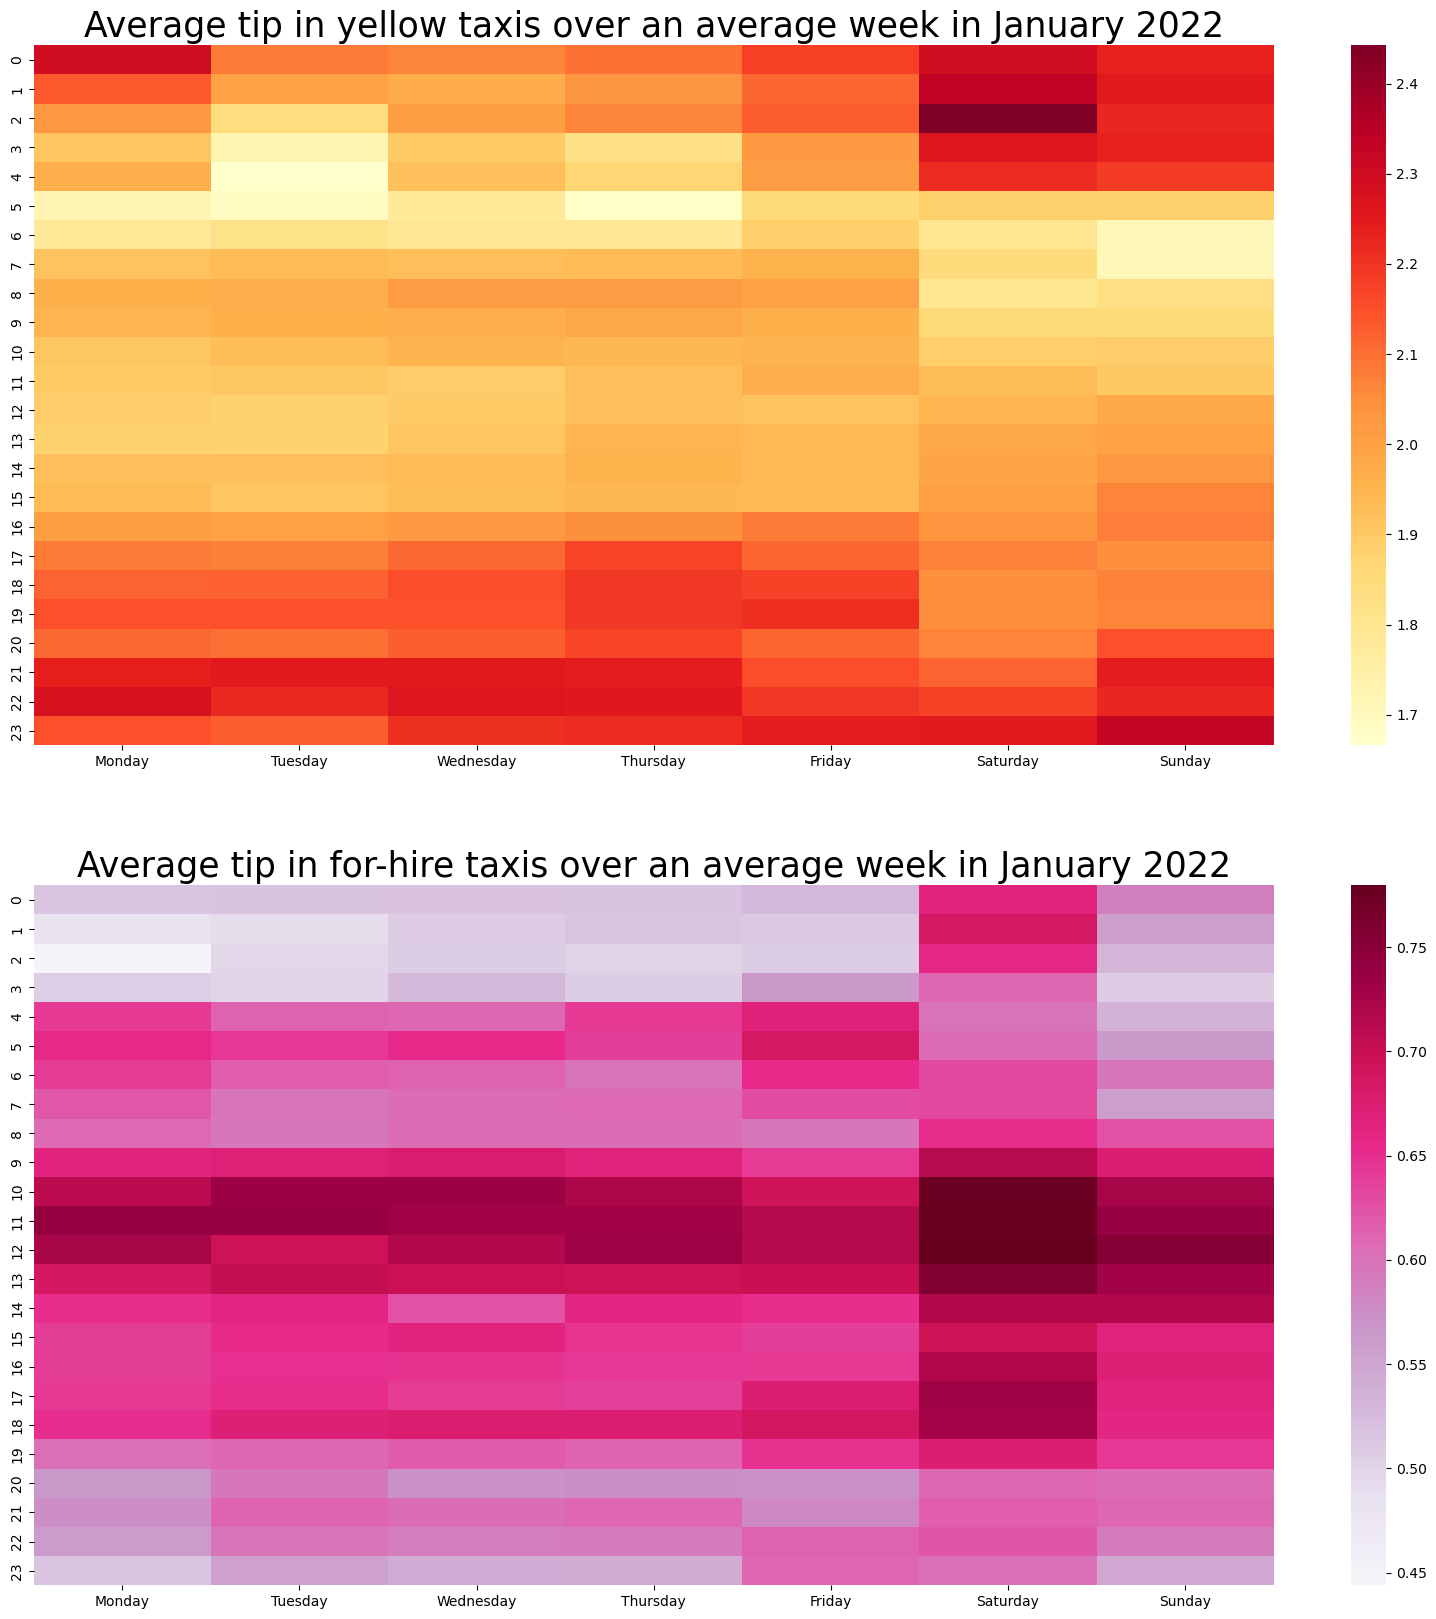

In [32]:
# use the weeklybreakdown() function defined in section 3, to filter our week on tips
y_weekly_tips = weeklybreakdown(ydata.copy(), 'tip_amount')[1]
fh_weekly_tips = weeklybreakdown(fhdata.copy(), 'tips')[1]

# create a subplot to compare yellow taxis and for-hire taxis 
figweektips, ax = plt.subplots(2,1, figsize=(20, 20))
ax[0].set_title('Average tip in yellow taxis over an average week in January 2022', fontsize = 25)
ax[1].set_title('Average tip in for-hire taxis over an average week in January 2022', fontsize = 25)

# create colorbar for the yellow taxis 
color = 'YlOrRd'
vmin, vmax = 0, y_weekly_tips.max().max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# plot heatmap of average yellow taxi tips over an average week 
sns.heatmap(y_weekly_tips, cmap = color, ax = ax[0])

# create colorbar for the for-hire taxis 
color = 'PuRd'
vmin, vmax = 0, fh_weekly_tips.max().max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# plot heatmap of average for-hire taxi tips over an average week 
sns.heatmap(fh_weekly_tips, cmap = color, ax = ax[1])

These heatmaps show where the average tip per taxi ride is the highest (dark) and where the average tip is the lowest (light). 

For yellow taxis we see that tipping is the highest early on Saturday and Sunday morning, at about 2am. We also see that beyond 5pm is when tipping increases everyday, and the worst time to get a tip is at about 5pm. This may be due to where rush our is (we know it's near 5pm from section 3 and 6), and where people take taxis the least (approximately 5am).

For the for-hire taxis we see that tipping occurs the most on Saturday between 10am and 6pm, this likely corresponds to tourists visiting on a Saturday. Outside of Saturday we see that 10am - 1pm is the best tipping time every other day, and early in the morning is the worst tipping time.

Surprisingly, the tipping charts between the two taxis don't line up perfectly, but instead the best and worst times are different. We do see that yellow taxis get tipped more, by the scale of the maximum average tips. If time allowed we would run this analysis over more months, to smooth out the plot. 

## 5.2 Tipping Location and Income Data, incl. Airports.
In this section we compare real life median household income data to average tipping locations, where a tip is located where the taxi begins its journey. We first find some income data from [4] and a shapefile of zip codes [5].

In [23]:
# get income data and zip_codes 
income_data = pd.read_csv('Median Incomes.csv')
zip_codes = gpd.read_file('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
zip_codes = zip_codes.sort_values(by = ['ZIPCODE'])

# sort through and format income data to only include data we want 
income_data = income_data.loc[income_data['Household Type'] == 'All Households']
income_data = income_data.loc[income_data['TimeFrame'] == 2018]
income_data.Location = income_data.Location.str.extract('(\d+)')
income_data = income_data.dropna()
income_data = income_data.rename(columns = {'Data':'Income'})
income_data = income_data.reindex()

# convert income data type to a float
income_data['Income'] = income_data['Income'].astype('float64')

# create a choropleth map out of the income data
income_choropleth = zip_codes.set_index('ZIPCODE').join(income_data.set_index('Location'))

# [4]
# New York Median Household Incomes
# Author: CCCNEWYORK
# URL: https://data.cccnewyork.org/data/table/66/median-incomes#66/107/62/a/a
# Last Accessed: 04/12/2022

# [5]
# New York Zip Code Boundaries
# Author: NYC Open Data
# URL: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true
# Last Accessed: 05/12/2022

In [24]:
# define the average tips map, based on the previous pick-up maps, which store tips
tips_map = y_PU_map.copy()
tips_map['count'] = y_PU_map['count'] + g_PU_map['count'] + fh_PU_map['count']
tips_map['tip_amount'] = y_PU_map['tip_amount'] + g_PU_map['tip_amount'] + fh_PU_map['tips']
tips_map['avg_tip'] = tips_map['tip_amount'] / tips_map['count']

<AxesSubplot:title={'center':'Average tip per taxi ride'}>

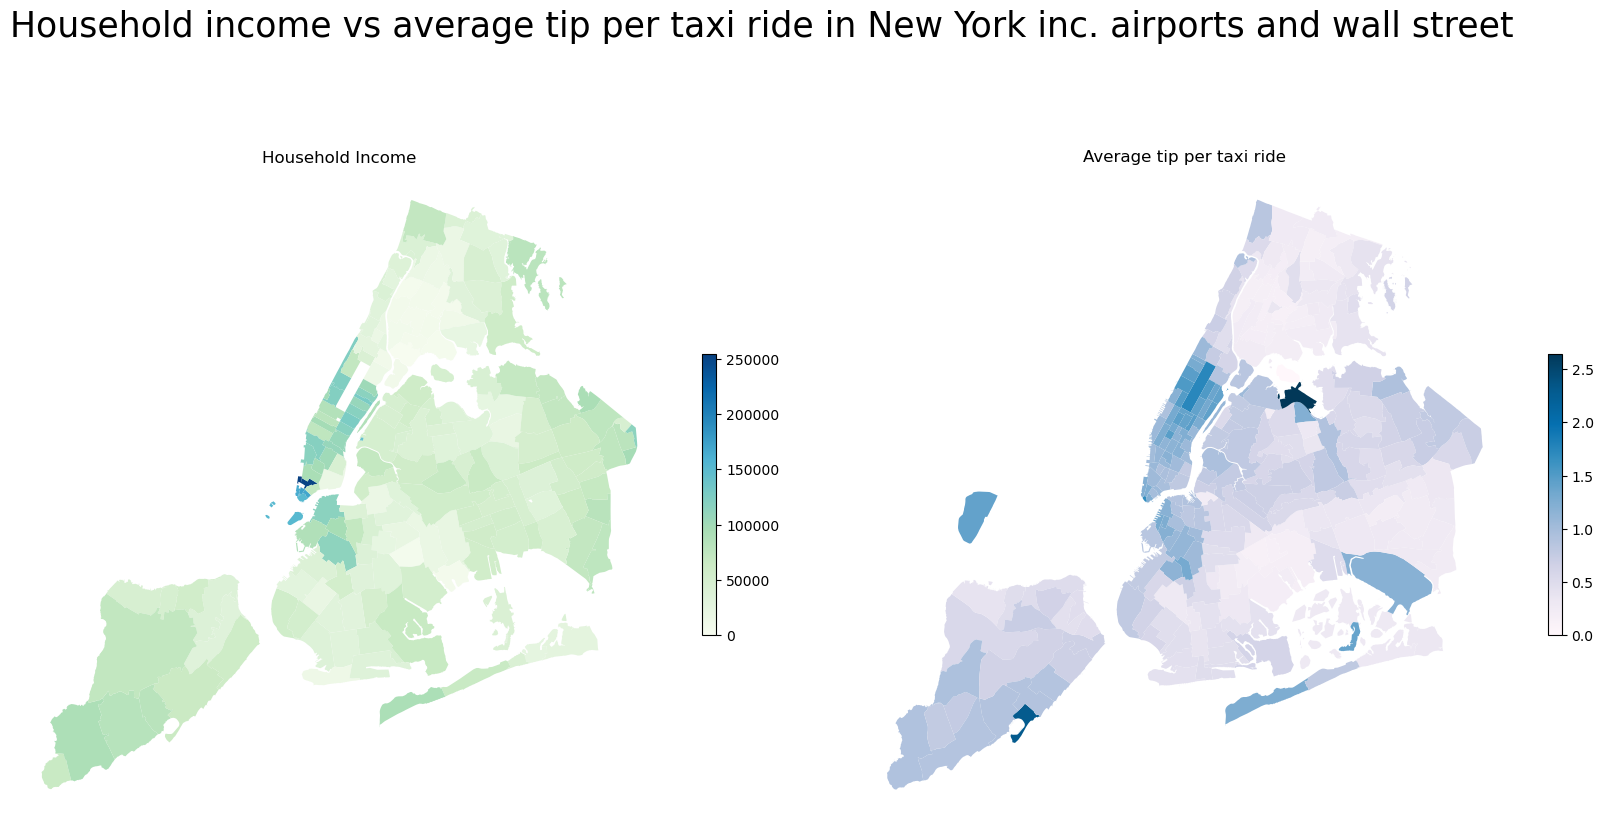

In [25]:
# plot income data and average tips on a choropleth 
figtips, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Household Income')
ax[1].set_title('Average tip per taxi ride')
figtips.suptitle('Household income vs average tip per taxi ride in New York inc. airports and wall street', fontsize = 25)

# get colorbar for income data
color = 'GnBu'
vmin, vmax = 0, income_data['Income'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figtips.colorbar(sm, ax = ax[0], fraction = .02)

# plot income data
income_choropleth.plot('Income', ax = ax[0], cmap=color, linewidth=0.8)

# get colorbar for tipping
color = 'PuBu'
vmin, vmax = 0, tips_map['avg_tip'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figtips.colorbar(sm, ax = ax[1], fraction = .02)

# plot tipping
tips_map.plot('avg_tip', ax = ax[1], cmap=color, linewidth=0.8)

Just like in section 5, we see that the airports are causing problems with high tipping, so we drop them in our data. We also see that the financial district has a really high median household income, as expected, so we will limit the income data in order to see more from the colouring. 

## 5.3 Tipping Location and Income Data excl. Airports, and with a cap on Median Income

In [26]:
# remove airports from tipping map 
tips_map_clean = tips_map.drop([1, 132, 138])

# ensure the median income is less that 250000 dollars
income_data_clean = income_data[income_data['Income'] < 250000]
income_choropleth_clean = zip_codes.set_index('ZIPCODE').join(income_data_clean.set_index('Location'))

<AxesSubplot:title={'center':'Average tip per taxi ride'}>

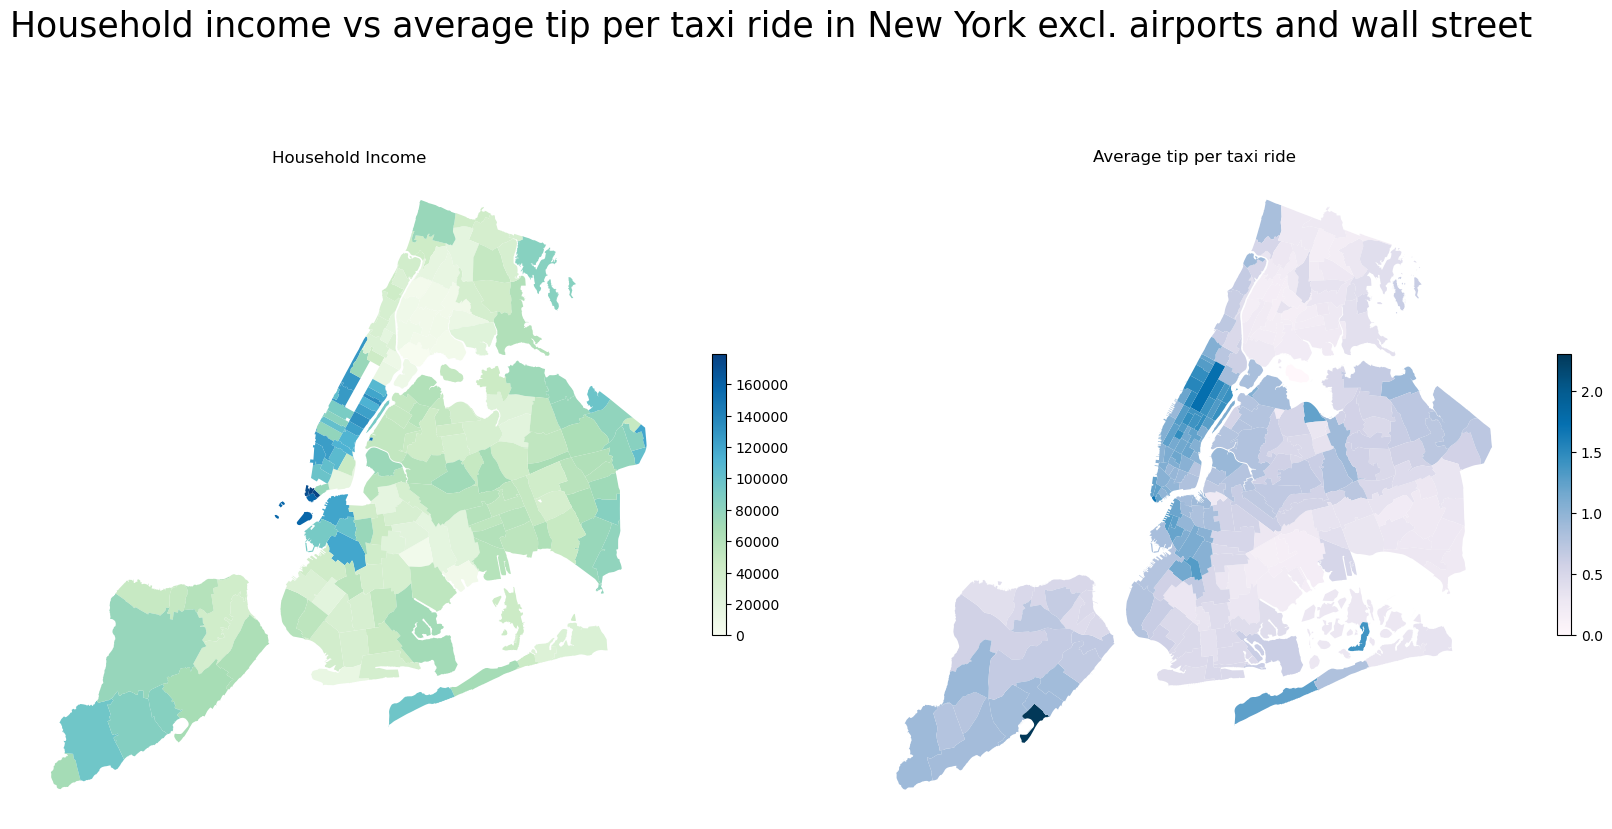

In [33]:
# plot income data and average tips on a choropleth 
figtips_clean, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Household Income')
ax[1].set_title('Average tip per taxi ride')
figtips_clean.suptitle('Household income vs average tip per taxi ride in New York excl. airports and wall street', fontsize = 25)

# get colorbar for income data
color = 'GnBu'
vmin, vmax = 0, income_data_clean['Income'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figtips_clean.colorbar(sm, ax = ax[0], fraction = .02)

# plot income data
income_choropleth_clean.plot('Income', ax = ax[0], cmap=color, linewidth=0.8)

# get colorbar for tipping
color = 'PuBu'
vmin, vmax = 0, tips_map_clean['avg_tip'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = figtips_clean.colorbar(sm, ax = ax[1], fraction = .02)

# plot tipping
tips_map_clean.plot('avg_tip', ax = ax[1], cmap=color, linewidth=0.8)

Much better! We see a strong correlation between the median household income and average tip by taxi zone!!! It can be seen that where the rich zip codes are (e.g Manhattan), the tipping is much higher, and tipping is less where the median income is not so high. 

This may not directly correlate, and there may be other factors in play like tourism, but since it lines up well there is a strong argument to be had that a larger median income leads to more tipping. 

We see that the most tipping occurs centrally around central park, and towards the outskirts of the city. Maybe on the outskirts people are taking longer journeys so are tipping more, but we have not studied length of journey in this report. 

# 6 Rush hour detection: 

Following on from the analysis on taxi pick-up times, we would like to know more about the rush hour of the taxis. It might be
useful for the taxi companies to change their strategies, like at what time should they send more taxis to what place.

## 6.1 Definition of a rush hours:
Before analyzing the data, we firstly give the definition of a 'rush hour' in order to quantify them. We use two different ways to define the rush hour.

*(1) Number of the taxis being hired*

The first way is to count the number of taxis being hired by passengers during a certain time period (e.g. one hour). If the number in a certain hour is larger than the number in other hours this hour can be defined as a rush hour in a day. This is the most direct way of defining the concept, and was studied in section 3. We effectively consider the number of passengers in each time period.

*(2) The ratio of duration and the distance of the travel*

We calculate the ratio of the duration and the distance of each journey. If the ratio is high, it means for a unit length, such as one kilometer, it needs to take a longer time to go pass one unit distance. This implies that there might be more cars on the road, like the traffic jam.

## 6.2 Rush hour functions

To analyse our data using this we implement some functions

- get_clean_data_rush_hour(): 
    Extract data with the given get_taxi_data() function and make the column names consistent across all taxis. Also add two new columns, duration and the duration-distance ratio. Then the data is cleaned by the previously defined functions and outliers are removed. 

- boxplot_period_dura_distance(): takes three parameters year, month and vehicle type and calls the get_clean_data_rush_hour() function. Then we separate the date and specific time. 'df['pickup_date']' contains the dates of January between 1 to 31, and 'df['pickup_time_zone']' contains the hours of a day between 0 to 23. 'groupeddf' contains, in each day (1 to 31), the corresponding total ratio of duration and distance in every time zone (0 to 23). Finally, we convert 'groupeddf' back to a data frame and form a pivot table for plotting the boxplots.
   
- boxplot_period_passenger_count(): same as boxplot_period_dura_distance() but considers passenger count instead of .
   

In [28]:
def get_clean_data_rush_hour(year,month,vehicles='yellow'):
    """get cleaned data with two new column duration and duration divided by distance 
    
    Parameters:
        df (pd.DataFrame):      Pandas dataframe we would like to clean.
        cols (list of strings): List of dataframe headers for which we would like to remove outliers from, 
                                defaulting to every column.
    
    Returns:
        df (pd.DataFrame): Cleaned dataframe with outliers removed and new column (duration and duration divided by distance) added. 
    """
    
    # choose our column headers, dependent on taxi type
    if vehicles=='yellow': 
        columns=['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','trip_distance','fare_amount']
        
    if vehicles=='green':
        columns=['lpep_pickup_datetime','lpep_dropoff_datetime','passenger_count','trip_distance','fare_amount']
        
    if vehicles=='fhvhv':
        columns=['pickup_datetime','dropoff_datetime','trip_time','trip_miles','base_passenger_fare']
        
    # retreive data using the given function
    df = get_taxi_data(year,month,vehicles,columns)
    
    # force add a trip_duration column before cleaning
    df = add_trip_duration(df)
    
    # rename column headers, to be consistent across all taxis
    df = df.rename(columns = {'trip_time':'trip_duration','trip_miles':'trip_distance','base_passenger_fare':'fare_amount',
                             'tpep_pickup_datetime': 'pickup_datetime', 'tpep_dropoff_datetime': 'dropoff_datetime',
                             'lpep_pickup_datetime': 'pickup_datetime', 'lpep_dropoff_datetime': 'dropoff_datetime'})
    
    # add duration / distance ratio column to dataframe
    df.insert(0, 'dura_distan', df['trip_duration'] / df['trip_distance'])

    # clean data using the functions defined in section 2
    df = impose_date(df, [year], [month])
    df = clean_data(df)
    df = remove_outliers(df)
    
    return df

In [29]:
def boxplot_period_dura_distance(year='2022',month='01',vehicles='yellow'):
    """plot boxplot of hourly passenger amount within one month. 
    
    Parameters:
        df (pd.DataFrame):         Cleaned dataframe with outliers removed and new column added.
        grouped_df (pd.DataFrame): passenger count summed within one hour.
        table_df (pd.DataFrame):   table of grouped dataframe that is ready to plot.
    
    Returns:
        Box plot of passenger count. 
    """
    
    # get cleaned data with duration and duration-distance ratio added
    df = get_clean_data_rush_hour(year,month,vehicles)
    
    # Separate the date and specific time, 'df['pickup_date']' contains the dates of January between 1 to 31
    df['pickup_date'] = df['pickup_datetime'].dt.date 
    
    # 'df['pickup_time_zone']' contains the hours of a day between 0 to 23
    df['pickup_time_zone'] = df['pickup_datetime'].dt.hour
    
    #'grouped_df' contains in each day(1 to 31), the corresponding total number of passenger in every time zone(0 to 23).
    grouped_df = df.groupby(['pickup_date','pickup_time_zone']).sum()['dura_distan'] 
    
    # Convert 'grouped_df' back to data frame and form a pivot table for plotting the boxplots
    grouped_df = pd.DataFrame(grouped_df)
    grouped_df = remove_outliers(grouped_df, columns = ['dura_distan'])
    
    table_df = pd.pivot_table(grouped_df,index=['pickup_date'],columns=['pickup_time_zone'],values=['dura_distan'])
    table_df.columns = [str(n) for n in range(24)]
    a = table_df.boxplot()
    
    a.plot()
    plt.xlabel("Time over a 24 hour period")
    plt.ylabel("Total Duration-Distance ratio")
    plt.title(f"Duration/Distance for {vehicles} taxis")
    plt.show()
    

In [30]:
def boxplot_period_passenger_count(year='2022',month='01',vehicles='yellow'):
    """plot boxplot of hourly passenger amount within one month. 
    
    Parameters:
        df (pd.DataFrame):     Cleaned dataframe with outliers removed and new column added.
        grouped_df (pd.DataFrame): passenger count summed within one hour.
        table_df (pd.DataFrame): table of grouped dataframe that is ready to plot.
    
    Returns:
        Box plot of passenger count. 
    """

    # get cleaned data with duration and duration-distance ratio added
    df = get_clean_data_rush_hour(year,month,vehicles)

    # Separate the date and specific time, 'df['pickup_date']' contains the dates of January between 1 to 31
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # 'df['pickup_time_zone']' contains the hours of a day between 0 to 23
    df['pickup_time_zone'] = df['pickup_datetime'].dt.hour
    
    # 'grouped_df' contains in each day (1 to 31), the total number of passenger in every time zone(0 to 23).
    #when we consider fhvhv, there is no passengers number given, so we just assume one passenger 
    if vehicles=='fhvhv':
        grouped_df = df.groupby(['pickup_date','pickup_time_zone']).size() #just calculate assume each time only one passenger.
    else: 
        grouped_df = df.groupby(['pickup_date','pickup_time_zone']).sum()['passenger_count']

    # Convert 'grouped_df' back to data frame and form a pivot table for plotting the boxplots
    grouped_df = pd.DataFrame(grouped_df)
    table_df = pd.pivot_table(grouped_df,index=['pickup_date'],columns=['pickup_time_zone'])
    table_df.columns = [str(n) for n in range(24)]
    a = table_df.boxplot()
    
    a.plot()
    plt.xlabel("Time over a 24 hour period")
    plt.ylabel("Total passenger count")
    plt.title(f"Passenger count for {vehicles} taxis")
    plt.show()

File not in current folder; trying to download data...


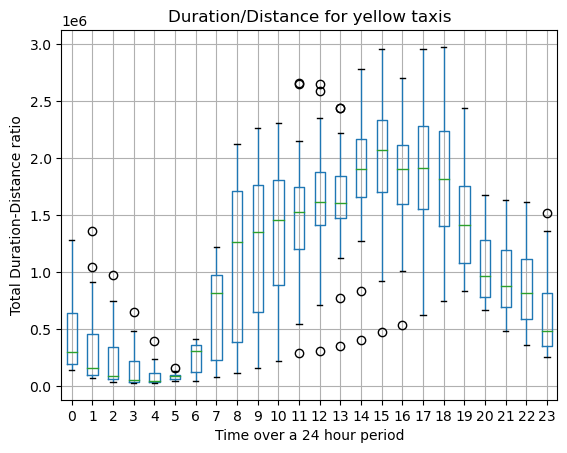

File not in current folder; trying to download data...


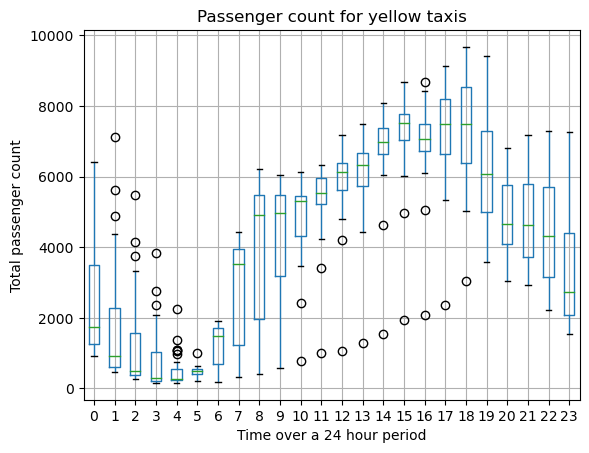

File not in current folder; trying to download data...


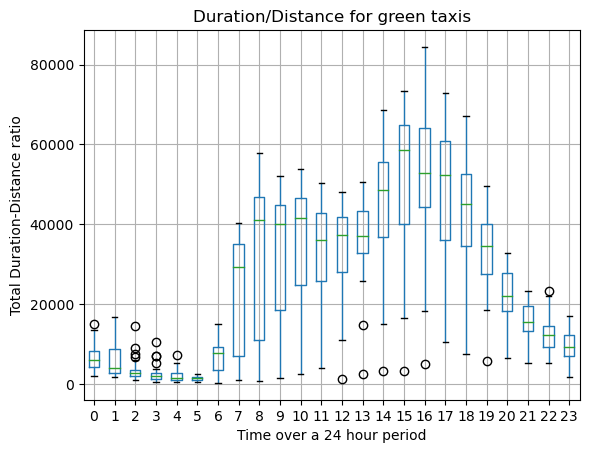

File not in current folder; trying to download data...


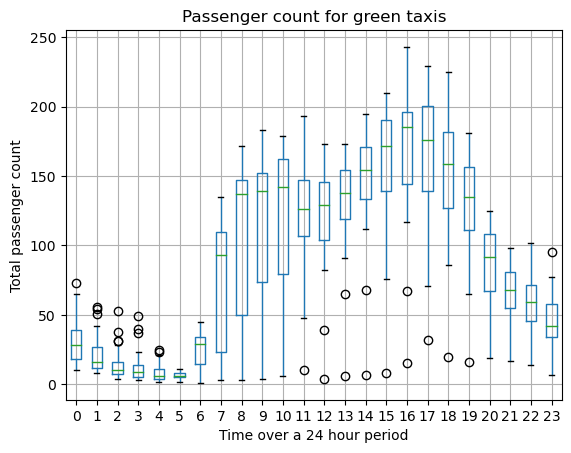

File not in current folder; trying to download data...


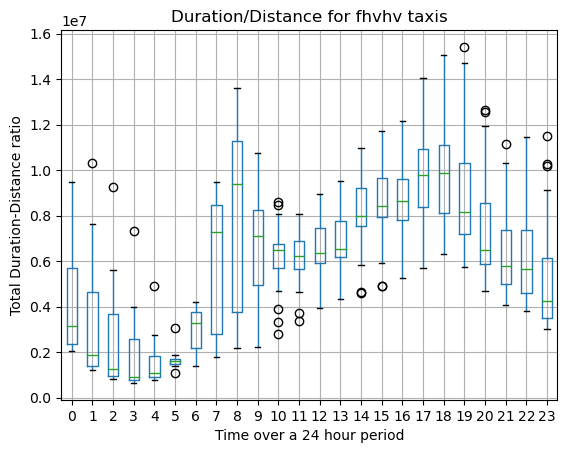

File not in current folder; trying to download data...


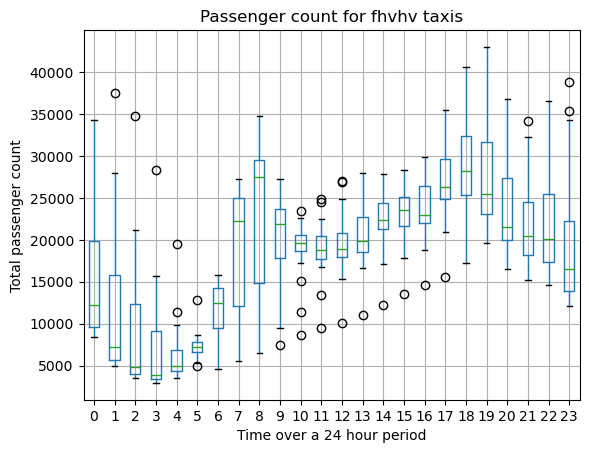

In [31]:
# call the boxplot function for yellow taxi, ratio of dura/distance
boxplot_period_dura_distance(year='2022',month='01',vehicles='yellow')

# call the boxplot function for yellow taxi, sum of passenger_count
boxplot_period_passenger_count(year='2022',month='01',vehicles='yellow') 

# call the boxplot function for green taxi, ratio of dura/distance
boxplot_period_dura_distance(year='2022',month='01',vehicles='green')

# call the boxplot function for green taxi, sum of passenger_count
boxplot_period_passenger_count(year='2022',month='01',vehicles='green')

# call the boxplot function for fhvhv taxi, ratio of dura/distance
boxplot_period_dura_distance(year='2022',month='01',vehicles='fhvhv')

# call the boxplot function for fhvhv taxi, sum of passenger_count
boxplot_period_passenger_count(year='2022',month='01',vehicles='fhvhv')

## 6.3 Results:

*The six plots show box plots for the hourly sum of the duration-distance ratio and the sum of passenger amount at time 2022-01 of vehicles yellow, green and fhvhv.*

*After drawing images for two different indicators of rush hours, we found that the results presented by the two definitions showed roughly the same trend. That is, for the two definitions, their “rush” estimate is similar, and the definitions are effectively the same.

*We see that pretty much all the taxi types act the same, so the comparison between them can't really be analysed, but we can analyse the overall trends.*

*5am is the most idle time. When the time is from 5am to 6pm, the 'busyness' was increasing gradually. The first peak appeared during 8am-10am. But when we look at 5pm to 6pm, the rush reached another huge peak. After that, it gradually decreased until it returned to the most idle time at 5:00am the next day.*

*These results are consistent with what we studied in section 3 but give a clearer indication of what is going on, and link our report back around nicely.*

*According to the result, we can recommend when and how many vehicle taxi suppliers should distribute (8am-10am and 5pm-6pm). When it turns to rush hour, they should increase their service supply to maximize profits by being able to carry all the potential passengers or planning for the most convenient distance. However, when the demand is small, they should reduce their service supply to reduce the idle time of service personnel and reduce their costs.*


# 7. Conclusion 
To summarise this report we focus on the differences and similarities between the yellow taxi and the for-hire taxi in January 2022. We find the following main results:
- The rush hours for both taxis are very similar. The main rush hours are between 8am-10am and 5pm-8pm. These can be seen in Sections 3 and 6.
- The for-hire vehicles pick up many more passengers over a much larger area (the whole of) new york, compared to the yellow taxis. 
- Yellow taxis have the biggest demand into and out of Manhattan, whereas for-hire vehicles are in demand on the outer boroughs of the city
- The yellow taxis receive more tips on average, and more consistently. 
- Tipping by location correlated very well with income data. The larger the median income at the taxi's pick-up location, the more tips a taxi driver receives.

